# Tuning of Hyperparameters in Simple Self-EFficacy Learner Model

This notebook includes code from iterating on the Self-Efficacy Learner Behavior Model including hyperparameters for generating the set of learners in the population.

In [1]:
import sys
sys.path.append("../")

In [2]:
import logging
import random
import uuid
import os
from collections.abc import Iterable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from tutor.domain import Domain
from tutor.cogtutor_curriculum import CogTutorCurriculum
from tutor.tutor import SimpleTutor
from tutor.action import Attempt, HintRequest
from learner.selfeff_learner import SelfEfficacyLearner


from simulate.self_eff_simulation import SelfEffSimulation
from log_db import mongo
from log_db.curriculum_mapper import DB_Curriculum_Mapper


In [4]:
logging.basicConfig(level=logging.DEBUG)
#logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("main")

In [5]:
# Get path to current project directory
cwd = os.path.abspath(".")
base_dir = os.path.abspath(os.path.join(cwd, os.pardir))
logger.debug("Base directory for the project:\n%s" % base_dir)

DEBUG:main:Base directory for the project:
/Users/stevenda/Sandbox/MotivSim


In [6]:
# Setup connection to database
data_out = "sim-%s" % str(uuid.uuid4())
data_path = os.path.join(base_dir,"test", "data", data_out)
logger.info("Writing simulation results to directory: %s" % data_path)
db_name = "motivsim"
db_params  = mongo.get_db_params(db_name)
logger.info("got db params: %s" % str(db_params))
db_util = mongo.Data_Utility(data_path, db_params)
db = db_util.db

INFO:main:Writing simulation results to directory: /Users/stevenda/Sandbox/MotivSim/test/data/sim-f779ba42-8bd4-4d9d-b6ee-9d2890cbd2b1
INFO:main:got db params: {'settingId': 'motivsim', 'url': 'localhost', 'port': '27017', 'name': 'motivsim', 'user': '', 'pswd': ''}


In [7]:
logger.info("Clearing database before starting new simulation")
db_util.clear_db()

INFO:main:Clearing database before starting new simulation
DEBUG:log_db.mongo:all collections in db: ['curriculum', 'sections', 'problems', 'curriculums', 'units', 'decisions', 'actions', 'students', 'tutor_events', 'steps', 'kcs', 'domains']
DEBUG:log_db.mongo:Clearing all documents from collection curriculum
DEBUG:log_db.mongo:Clearing all documents from collection sections
DEBUG:log_db.mongo:Clearing all documents from collection problems
DEBUG:log_db.mongo:Clearing all documents from collection curriculums
DEBUG:log_db.mongo:Clearing all documents from collection units
DEBUG:log_db.mongo:Clearing all documents from collection decisions
DEBUG:log_db.mongo:Clearing all documents from collection actions
DEBUG:log_db.mongo:Clearing all documents from collection students
DEBUG:log_db.mongo:Clearing all documents from collection tutor_events
DEBUG:log_db.mongo:Clearing all documents from collection steps
DEBUG:log_db.mongo:Clearing all documents from collection kcs
DEBUG:log_db.mongo:Cle

## Generating Learners

### Setting up Simulation

In [8]:
# Generating empty domain
domain = Domain()

In [9]:
# Generating the Curriculum and domain together
'''
curric = CogTutorCurriculum(domain)
curric.generate(num_units=1,
               mean_sections=4,
               stdev_sections=2,
               mean_unit_kcs=22,
               stdev_unit_kcs=23,
               section_kcs_lambda=6,
               mean_steps=10,
               stdev_steps=4,
               mean_prob_kcs=6,
               stdev_prob_kcs=3,
               num_practice=100)
'''

'\ncurric = CogTutorCurriculum(domain)\ncurric.generate(num_units=1,\n               mean_sections=4,\n               stdev_sections=2,\n               mean_unit_kcs=22,\n               stdev_unit_kcs=23,\n               section_kcs_lambda=6,\n               mean_steps=10,\n               stdev_steps=4,\n               mean_prob_kcs=6,\n               stdev_prob_kcs=3,\n               num_practice=100)\n'

In [10]:
# Generating the Curriculum and domain together
curric = CogTutorCurriculum(domain)
curric.generate(num_units=1,
               mean_sections=1,
               stdev_sections=0,
               mean_unit_kcs=5,
               stdev_unit_kcs=1,
               section_kcs_lambda=6,
               mean_steps=4,
               stdev_steps=1,
               mean_prob_kcs=3,
               stdev_prob_kcs=1,
               num_practice=100)

DEBUG:tutor.cogtutor_curriculum:Generating curriculum for <class 'tutor.cogtutor_curriculum.CogTutorCurriculum'>
DEBUG:tutor.cogtutor_curriculum:Generating unit #0 with 1 sections
DEBUG:tutor.cogtutor_curriculum:Generating section #0 with 7 kcs
DEBUG:tutor.domain:generate kcs for domain: 51541d25-fb28-442a-8305-5ca4f6ab5332
DEBUG:tutor.domain:Generating kc #0
DEBUG:tutor.domain:KC: pl0: 0.592230	pt: 0.289855	pg: 0.010000	ps: 0.967635	mtime: 12.122160	 sdtime: 3.030540
DEBUG:tutor.domain:Generating kc #1
DEBUG:tutor.domain:KC: pl0: 0.372642	pt: 0.238551	pg: 0.067902	ps: 0.604852	mtime: 18.260718	 sdtime: 4.565179
DEBUG:tutor.domain:Generating kc #2
DEBUG:tutor.domain:KC: pl0: 0.415872	pt: 0.155155	pg: 0.081500	ps: 0.895473	mtime: 16.464625	 sdtime: 4.116156
DEBUG:tutor.domain:Generating kc #3
DEBUG:tutor.domain:KC: pl0: 0.460550	pt: 0.183285	pg: 0.092809	ps: 0.740393	mtime: 15.546305	 sdtime: 3.886576
DEBUG:tutor.domain:Generating kc #4
DEBUG:tutor.domain:KC: pl0: 0.540568	pt: 0.207349	

DEBUG:tutor.cogtutor_curriculum:Added problem with 7 steps and 6 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 14
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 8, <tutor.domain.KC object at 0x112e1dca0>: 8, <tutor.domain.KC object at 0x112e2e2e0>: 8, <tutor.domain.KC object at 0x112e2e0a0>: 9, <tutor.domain.KC object at 0x112e1dc70>: 9, <tutor.domain.KC object at 0x112e1da60>: 8, <tutor.domain.KC object at 0x112e38d60>: 10}
DEBUG:tutor.cogtutor_curriculum:Added problem with 4 steps and 2 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 15
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 11, <tutor.domain.KC object at 0x112e1dca0>: 8, <tutor.domain.KC object at 0x112e2e2e0>: 8, <tutor.domain.KC object at 0x112e2e0a0>: 9, <tutor.domain.KC object at 0x112e1dc70>: 10, <tutor.domain.KC object at 0x112e1da60>: 8, <tutor.domain.KC object a

DEBUG:tutor.cogtutor_curriculum:Added problem with 2 steps and 2 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 30
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 22, <tutor.domain.KC object at 0x112e1dca0>: 23, <tutor.domain.KC object at 0x112e2e2e0>: 19, <tutor.domain.KC object at 0x112e2e0a0>: 16, <tutor.domain.KC object at 0x112e1dc70>: 23, <tutor.domain.KC object at 0x112e1da60>: 14, <tutor.domain.KC object at 0x112e38d60>: 15}
DEBUG:tutor.cogtutor_curriculum:Added problem with 3 steps and 3 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 31
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 23, <tutor.domain.KC object at 0x112e1dca0>: 23, <tutor.domain.KC object at 0x112e2e2e0>: 19, <tutor.domain.KC object at 0x112e2e0a0>: 17, <tutor.domain.KC object at 0x112e1dc70>: 24, <tutor.domain.KC object at 0x112e1da60>: 14, <tutor.domain.K

DEBUG:tutor.cogtutor_curriculum:Added problem with 5 steps and 4 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 46
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 32, <tutor.domain.KC object at 0x112e1dca0>: 29, <tutor.domain.KC object at 0x112e2e2e0>: 29, <tutor.domain.KC object at 0x112e2e0a0>: 24, <tutor.domain.KC object at 0x112e1dc70>: 33, <tutor.domain.KC object at 0x112e1da60>: 21, <tutor.domain.KC object at 0x112e38d60>: 21}
DEBUG:tutor.cogtutor_curriculum:Added problem with 7 steps and 5 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 47
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 33, <tutor.domain.KC object at 0x112e1dca0>: 29, <tutor.domain.KC object at 0x112e2e2e0>: 29, <tutor.domain.KC object at 0x112e2e0a0>: 25, <tutor.domain.KC object at 0x112e1dc70>: 34, <tutor.domain.KC object at 0x112e1da60>: 23, <tutor.domain.K

DEBUG:tutor.cogtutor_curriculum:Added problem with 2 steps and 1 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 62
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 43, <tutor.domain.KC object at 0x112e1dca0>: 35, <tutor.domain.KC object at 0x112e2e2e0>: 36, <tutor.domain.KC object at 0x112e2e0a0>: 32, <tutor.domain.KC object at 0x112e1dc70>: 42, <tutor.domain.KC object at 0x112e1da60>: 32, <tutor.domain.KC object at 0x112e38d60>: 31}
DEBUG:tutor.cogtutor_curriculum:Added problem with 6 steps and 5 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 63
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 43, <tutor.domain.KC object at 0x112e1dca0>: 36, <tutor.domain.KC object at 0x112e2e2e0>: 37, <tutor.domain.KC object at 0x112e2e0a0>: 33, <tutor.domain.KC object at 0x112e1dc70>: 43, <tutor.domain.KC object at 0x112e1da60>: 34, <tutor.domain.K

DEBUG:tutor.cogtutor_curriculum:Added problem with 5 steps and 5 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 78
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 49, <tutor.domain.KC object at 0x112e1dca0>: 50, <tutor.domain.KC object at 0x112e2e2e0>: 45, <tutor.domain.KC object at 0x112e2e0a0>: 45, <tutor.domain.KC object at 0x112e1dc70>: 52, <tutor.domain.KC object at 0x112e1da60>: 48, <tutor.domain.KC object at 0x112e38d60>: 41}
DEBUG:tutor.cogtutor_curriculum:Added problem with 3 steps and 2 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 79
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 50, <tutor.domain.KC object at 0x112e1dca0>: 50, <tutor.domain.KC object at 0x112e2e2e0>: 45, <tutor.domain.KC object at 0x112e2e0a0>: 45, <tutor.domain.KC object at 0x112e1dc70>: 52, <tutor.domain.KC object at 0x112e1da60>: 50, <tutor.domain.K

DEBUG:tutor.cogtutor_curriculum:Added problem with 5 steps and 5 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 94
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 57, <tutor.domain.KC object at 0x112e1dca0>: 58, <tutor.domain.KC object at 0x112e2e2e0>: 52, <tutor.domain.KC object at 0x112e2e0a0>: 56, <tutor.domain.KC object at 0x112e1dc70>: 66, <tutor.domain.KC object at 0x112e1da60>: 63, <tutor.domain.KC object at 0x112e38d60>: 48}
DEBUG:tutor.cogtutor_curriculum:Added problem with 5 steps and 5 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 95
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 58, <tutor.domain.KC object at 0x112e1dca0>: 59, <tutor.domain.KC object at 0x112e2e2e0>: 52, <tutor.domain.KC object at 0x112e2e0a0>: 57, <tutor.domain.KC object at 0x112e1dc70>: 66, <tutor.domain.KC object at 0x112e1da60>: 64, <tutor.domain.K

DEBUG:tutor.cogtutor_curriculum:Added problem with 4 steps and 4 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 110
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 63, <tutor.domain.KC object at 0x112e1dca0>: 69, <tutor.domain.KC object at 0x112e2e2e0>: 56, <tutor.domain.KC object at 0x112e2e0a0>: 64, <tutor.domain.KC object at 0x112e1dc70>: 80, <tutor.domain.KC object at 0x112e1da60>: 70, <tutor.domain.KC object at 0x112e38d60>: 56}
DEBUG:tutor.cogtutor_curriculum:Added problem with 1 steps and 1 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 111
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 63, <tutor.domain.KC object at 0x112e1dca0>: 69, <tutor.domain.KC object at 0x112e2e2e0>: 56, <tutor.domain.KC object at 0x112e2e0a0>: 64, <tutor.domain.KC object at 0x112e1dc70>: 80, <tutor.domain.KC object at 0x112e1da60>: 70, <tutor.domain

DEBUG:tutor.cogtutor_curriculum:Added problem with 3 steps and 3 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 126
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 74, <tutor.domain.KC object at 0x112e1dca0>: 80, <tutor.domain.KC object at 0x112e2e2e0>: 67, <tutor.domain.KC object at 0x112e2e0a0>: 71, <tutor.domain.KC object at 0x112e1dc70>: 88, <tutor.domain.KC object at 0x112e1da60>: 78, <tutor.domain.KC object at 0x112e38d60>: 64}
DEBUG:tutor.cogtutor_curriculum:Added problem with 6 steps and 6 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 127
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 75, <tutor.domain.KC object at 0x112e1dca0>: 81, <tutor.domain.KC object at 0x112e2e2e0>: 68, <tutor.domain.KC object at 0x112e2e0a0>: 71, <tutor.domain.KC object at 0x112e1dc70>: 89, <tutor.domain.KC object at 0x112e1da60>: 79, <tutor.domain

DEBUG:tutor.cogtutor_curriculum:Added problem with 1 steps and 1 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 142
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 82, <tutor.domain.KC object at 0x112e1dca0>: 86, <tutor.domain.KC object at 0x112e2e2e0>: 77, <tutor.domain.KC object at 0x112e2e0a0>: 82, <tutor.domain.KC object at 0x112e1dc70>: 97, <tutor.domain.KC object at 0x112e1da60>: 91, <tutor.domain.KC object at 0x112e38d60>: 69}
DEBUG:tutor.cogtutor_curriculum:Added problem with 6 steps and 4 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 143
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 83, <tutor.domain.KC object at 0x112e1dca0>: 86, <tutor.domain.KC object at 0x112e2e2e0>: 77, <tutor.domain.KC object at 0x112e2e0a0>: 84, <tutor.domain.KC object at 0x112e1dc70>: 99, <tutor.domain.KC object at 0x112e1da60>: 92, <tutor.domain

DEBUG:tutor.cogtutor_curriculum:Added problem with 3 steps and 1 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 158
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 95, <tutor.domain.KC object at 0x112e1dca0>: 89, <tutor.domain.KC object at 0x112e2e2e0>: 87, <tutor.domain.KC object at 0x112e2e0a0>: 89, <tutor.domain.KC object at 0x112e1dc70>: 107, <tutor.domain.KC object at 0x112e1da60>: 100, <tutor.domain.KC object at 0x112e38d60>: 81}
DEBUG:tutor.cogtutor_curriculum:Added problem with 5 steps and 4 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 159
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 97, <tutor.domain.KC object at 0x112e1dca0>: 89, <tutor.domain.KC object at 0x112e2e2e0>: 87, <tutor.domain.KC object at 0x112e2e0a0>: 89, <tutor.domain.KC object at 0x112e1dc70>: 108, <tutor.domain.KC object at 0x112e1da60>: 101, <tutor.do

DEBUG:tutor.cogtutor_curriculum:Added problem with 5 steps and 4 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 174
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 109, <tutor.domain.KC object at 0x112e1dca0>: 96, <tutor.domain.KC object at 0x112e2e2e0>: 92, <tutor.domain.KC object at 0x112e2e0a0>: 97, <tutor.domain.KC object at 0x112e1dc70>: 117, <tutor.domain.KC object at 0x112e1da60>: 108, <tutor.domain.KC object at 0x112e38d60>: 89}
DEBUG:tutor.cogtutor_curriculum:Added problem with 2 steps and 2 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 175
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 109, <tutor.domain.KC object at 0x112e1dca0>: 96, <tutor.domain.KC object at 0x112e2e2e0>: 92, <tutor.domain.KC object at 0x112e2e0a0>: 97, <tutor.domain.KC object at 0x112e1dc70>: 117, <tutor.domain.KC object at 0x112e1da60>: 109, <tutor.

DEBUG:tutor.cogtutor_curriculum:Added problem with 4 steps and 2 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 190
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 124, <tutor.domain.KC object at 0x112e1dca0>: 102, <tutor.domain.KC object at 0x112e2e2e0>: 108, <tutor.domain.KC object at 0x112e2e0a0>: 105, <tutor.domain.KC object at 0x112e1dc70>: 126, <tutor.domain.KC object at 0x112e1da60>: 118, <tutor.domain.KC object at 0x112e38d60>: 97}
DEBUG:tutor.cogtutor_curriculum:Added problem with 5 steps and 4 kcs
DEBUG:tutor.cogtutor_curriculum:Number of problems: 191
DEBUG:tutor.cogtutor_curriculum:Total kcs: 7	kcs with completed practice:
 {<tutor.domain.KC object at 0x112e1dbb0>: 125, <tutor.domain.KC object at 0x112e1dca0>: 102, <tutor.domain.KC object at 0x112e2e2e0>: 110, <tutor.domain.KC object at 0x112e2e0a0>: 106, <tutor.domain.KC object at 0x112e1dc70>: 126, <tutor.domain.KC object at 0x112e1da60>: 118, <

In [11]:
# Insert domain to db
db.domains.insert_one(domain.to_dict())
db.kcs.insert_many([kc.__dict__ for kc in domain.kcs])

# Insert Curriculum to db
curric_util = DB_Curriculum_Mapper(db_params)
curric_util.write_to_db(curric)

INFO:log_db.curriculum_mapper:Writing curriculum with id, c3b09307-7361-4c93-a8d0-bb52485c863e, to db
DEBUG:log_db.curriculum_mapper:ID before writing: c3b09307-7361-4c93-a8d0-bb52485c863e
DEBUG:log_db.curriculum_mapper:Successfully written to db collection, 'curriculums', with id: c3b09307-7361-4c93-a8d0-bb52485c863e
DEBUG:log_db.curriculum_mapper:IDs before writing: ['20cdd877-13a9-4d9c-b817-a9a9e755cfc5']
DEBUG:log_db.curriculum_mapper:Successfully written to db collection, 'units', with ids: ['20cdd877-13a9-4d9c-b817-a9a9e755cfc5']
DEBUG:log_db.curriculum_mapper:IDs before writing: ['1436acbe-318e-4535-b9fd-652fdc150763']
DEBUG:log_db.curriculum_mapper:Successfully written to db collection, 'sections', with ids: ['1436acbe-318e-4535-b9fd-652fdc150763']
INFO:log_db.curriculum_mapper:Writing 194 problem to db
DEBUG:log_db.curriculum_mapper:IDs before writing: ['dc916506-c462-48d0-a671-4cfeacd4333f', 'db1c5826-d49c-48b6-a11a-95f23cdf5ac4', '04cf1011-690b-4a1f-8d9c-fcb08704fc7a', '40e1

### Initializing Learners

In [12]:
num_students = 2
students = [SelfEfficacyLearner(domain) for i in range(num_students)]
logger.info("Sample student:\n%s" % str(students[0]))
logger.info("Inserting %i students to db" % len(students))
result = db.students.insert_many([stu.to_dict() for stu in students])
logger.info("Db insert success: %s" % result.acknowledged)

INFO:main:Sample student:
INFO:main:Inserting 2 students to db
INFO:main:Db insert success: True


### Simulating Learners

In [13]:
for i, stu in enumerate(students):
    logger.info("Simulating student #%i" % i)
    sim = SelfEffSimulation(domain, curric, stu)
    sim.run()

INFO:main:Simulating student #0
DEBUG:tutor.tutor:Initializing student model for simple list of kcs
DEBUG:tutor.tutor:available units: [<tutor.curriculum.Unit object at 0x112c80ee0>]
DEBUG:tutor.tutor:Total section kcs: 7	Unmastered kcs: 7	target kc: efee908e-dfc0-472c-b4f5-0b343c3b8bd5
DEBUG:tutor.tutor:Current have 88 available problems
DEBUG:tutor.tutor:Selected problem: <tutor.curriculum.Problem object at 0x112e786a0>
INFO:simulate.simulation:Starting simulation. Logging student into new session
DEBUG:tutor.tutor:Attempting Starting new session
DEBUG:tutor.tutor:Logging start of new session: 2020-10-08 20:56:01.267439
DEBUG:tutor.tutor:session start: {'_id': <pymongo.results.InsertOneResult object at 0x112ed60c0>, 'type': 'Session Start', 'time': datetime.datetime(2020, 10, 8, 20, 56, 1, 267439)}
DEBUG:tutor.tutor:Created session and logged user in
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculati

DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'fadb543b-9e20-444c-a265-af20965b0956', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 3.5796636985440666}, 'time': datetime.datetime(2020, 10, 8, 20, 56, 4, 310911)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 20:56:07.890575
DEBUG:tutor.tutor:Processing student hint request
DEBUG:tutor.tutor:Hints avail: 2	Hints use: 1
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': '23cc648c-cd13-42f2-a892-dc2dae2735c2', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 20, 56, 7, 890575), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, 'pt': 0.14594627579666575, 'ps': 0.04500655707883253, 'pg': 0.7469258601026727, 'm_time': 13.233142736488542, 'sd_time': 3.3082856841221355}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '41606793-0bdc-415a-b391-d69c118432cb', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 3.7349142563237345}, 'time': datetime.datetime(2020, 10, 8, 20, 56,

DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'f6bc28c7-d849-4c86-bfa1-9391bdf60302', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 20, 56, 31, 262781), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '59184f41-1880-42c6-a001-1d8f41cc0964', 'step': '4221ab13-f132-4013-9622-4e430caf50a2', 'kc': {'_id': '0dd53b3f-5620-4b71-b45a-7023a536a656', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5922304924945687, 'pt': 0.2898551188634424, 'ps': 0.01, 'pg': 0.9676350480229159, 'm_time': 12.122160303718218, 'sd_time': 3.0305400759295544}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_l

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy 

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'b117713b-06e7-4ff9-9755-8d5ea68dea5d', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 8, 21, 4, 27, 94152), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '59184f41-1880-42c6-a001-1d8f41cc0964', 'step': 'c103e88e-083f-4b41-ab36-5c30

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'bcd2613e-2498-460a-945f-e112ade02bfc', 'student_id': UUID('1b8bd748-eabf-4992

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.00763358

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.349181	 updated plt: 0.498095
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': '30467033-830f-4a57-a8bb-12a527b74590', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 21, 25, 47, 65489), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'a8ee36f4-ed43-4ca5-9bbf-34e5d418ace5', 'step_id': '2a1d8348-1343-494a-b73c-024766465891', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 10.14852329809779, 'outcome': 'Correct', 'kcs': [{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt':

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'b6f036d9-8aab-4342-8b4b-c8596a07cd3c', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 13.211571717579183, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 21, 25, 48, 120265)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 21:26:01.331837
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dca0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '14b64cd1-079b-4b3b-955f-684

DEBUG:learner.selfeff_learner:Logging decision: {'_id': '80aeb990-e8ba-4753-be9a-e922c793688e', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 21, 26, 1, 331837), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'a8ee36f4-ed43-4ca5-9bbf-34e5d418ace5', 'step': 'e5a4d0ce-31f6-481f-98c4-96738253146b', 'kc': {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}, 'learner_knowledge': True, 'attempt': 1}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.00763358

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Latest input time: 2020-10-08 21:28:49.555170
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.292906	 updated plt: 0.535236
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dca0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '34a62935-bd47-4dee-a42c-d41e07a88538', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 21, 28, 49, 555170), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '68f472fa-c8de-4a18-8393-8781fcb09645', 'step_id': 'a9862faa-ed76-43ea-810d-4e026b3fa27d', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 16.490238101686582, 'outcome': 'Correct', 'kcs': [{'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.5651794490834}
DEBUG:learner.learner:Probability of learning skill: 0.238551	 learned?: False
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '7679f7c8-dd79-447a-a21d-79ac13f2eeed', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 11.383273954302432, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 21, 2

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'de525e32-9120-4c8b-b467-3237dbd908fa', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 21, 29, 37, 85661), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '8b27cd45-a601-42d2-a8e3-ad939905bf08', 'step': 'a9530aee-bd41-4133-9a71-93a4db4

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Latest input time: 2020-10-08 21:30:27.733076
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.532306	 updated plt: 0.644369
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'af65e631-e40d-45f4-8662-61e4cda3f964', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 21, 30, 27, 733076), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '8b27cd45-a601-42d2-a8e3-ad939905bf08', 'step_id': '96a995c6-e562-4e11-83e5-ccc57a0c5a63', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 9.933452988312938, 'outcome': 'Correct', 'kcs': [{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '9e7d90f7-4e81-433a-9f27-56a617ca2956', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 15.713907915541387, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 21, 30, 31, 703914)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 21:30:47.417822
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e2e0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'b4524774-f590-4455-819c-093

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'a5c353bd-2e1c-434c-9d0c-ad70ebff906f', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 21, 31, 9, 711405), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '3b84193c-0aa1-4822-a494-103ace2346c1', 'step': '8882f6b4-f7bb-4e03-b67c-a3f57e4ca384', 'kc': {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}, 'learner_know

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: 

DEBUG:tutor.tutor:Total section kcs: 7	Unmastered kcs: 7	target kc: efee908e-dfc0-472c-b4f5-0b343c3b8bd5
DEBUG:tutor.tutor:Current have 84 available problems
DEBUG:tutor.tutor:Selected problem: <tutor.curriculum.Problem object at 0x112e958e0>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG

DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e2e0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'af95d880-9332-4982-921a-5d1116129bcb', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 21, 31, 57, 423191), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '076ac487-998e-4357-b4f7-48a6f4bee138', 'step_id': '57d2b57c-34ed-4d2b-9f96-a8b8ff67b951', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 18.112909399892775, 'outcome': 'Correct', 'kcs': [{'_id': 'efee908e-dfc0-472c-b4f5-0b343c3b8bd5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4158718066535876, 'pt': 0.1551550302284144, 'ps': 0.0815004388062501, 'pg': 0.8954727652871164, 'm_time': 16.464624732357535, 'sd_time': 4.116156183089384}], 'plt': 0.723535454934195

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '809fe078-c27d-4abe-bf45-9302c0c95ea5', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 10.404088636960902, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 21, 32, 12, 213

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '414f7920-f64a-4ef8-bedf-1fcfcfdbd673', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 21, 32, 24, 342889), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05},

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: 

DEBUG:tutor.tutor:Outcome: False	Prior plt: 0.849945	 updated plt: 0.614132
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dca0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'da2e8cc6-7d30-4ed5-80d5-b09e60d293ef', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 21, 33, 25, 494728), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '9663f91b-4988-4236-a82b-fd5c8b43949e', 'step_id': '052859c9-437b-4c78-b7b4-9ec4e34ba145', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 14.46528757711406, 'outcome': 'Incorrect', 'kcs': [{'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.565179

DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '0a7018f7-b5c4-4ea9-94e2-67cefa71043e', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 9.728276334473357, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 21, 33, 43, 63381)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 21:33:52.791657
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.799187	 updated plt: 0.850357
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': '52824cfa-75dd-4101-a0b4-b1e6371f44e0', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 21, 33, 52, 791657), 'curric_id': 'c3b09307-7361-4c93-

DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'efee908e-dfc0-472c-b4f5-0b343c3b8bd5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4158718066535876, 'pt': 0.1551550302284144, 'ps': 0.0815004388062501, 'pg': 0.8954727652871164, 'm_time': 16.464624732357535, 'sd_time': 4.116156183089384}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '7d4025b2-4d5e-4517-9fbb-88dfaff7bbeb', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 14.057119965643368, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 21, 41, 29, 90564)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 21:41:43.147684
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '5a6647a7-4831-4c2b-b3e5-e92977fae2a0', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'OffTask', 'time': datetime.datetime(2020, 10, 8, 21, 41, 48, 196053), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '8a07e1ab-8bd1-4511-b54b-0cbc1268f77d', 'step': 'c3a5ef72-d3ba-4cea-80e2-8054fc434d20', 'kc': {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}, 'learner_kno

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.5651794490834}
DEBUG:learner.learner:Probability of learning skill: 0.238551	 learned?: False
DEBUG:learner.selfeff_learner:Return action: Off Task
DEBUG:learner.selfeff_learner:Logged action: {'_id': '92121ae6-232f-4da1-b983-a78a86fbdd96', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Off Task', 'time': 421.2847042604874}, 'time': datetime.datetime(2020, 10, 8, 2

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'b746f98e-c7a3-4602-9fb1-c67939a0f888', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 18.624973895154568, 'is_correct': False}, 'time': datetime.datetime(2020, 10, 8, 21, 50, 35, 374857)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 21:50:53.999831
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dca0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'dc4dae90-c7d8-464e-8eb6-18

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Skill to update: {'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4019143599898649, 'pt': 0.22038279294717625, 'ps': 0.030256068263264806, 'pg': 0.99, 'm_time': 17.52789790152027, 'sd_time': 4.381974475380067}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Off Task
DEBUG:learner.selfeff_learner:Logged action: {'_id': '2e80a9f4-93cb-4e3f-90bc-79c3998de366', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Off Task', 'time': 817.2652181356906}, 'time': datetime.datetime(2020, 10, 8, 21, 51, 7, 664900)}


DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': '0dd53b3f-5620-4b71-b45a-7023a536a656', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5922304924945687, 'pt': 0.2898551188634424, 'ps': 0.01, 'pg': 0.9676350480229159, 'm_time': 12.122160303718218, 'sd_time': 3.0305400759295544}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '2f592b2e-2f51-4ec7-9660-62c1b6f667a9', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 2.867165659802392}, 'time': datetime.datetime(2020, 10, 8, 22, 4, 47, 784235)}
DEBU

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, 'pt': 0.14594627579666575, 'ps': 0.04500655707883253, 'pg': 0.7469258601026727, 'm_time': 13.233142736488542, 'sd_time': 3.3082856841221355}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '07dc999f-147c-4560-ab1d-48d6e15d2029', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 1.641666443711468}, 'time': datetime.datetime(2020, 10, 8, 22, 4, 5

DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'c926cec5-c95a-46c8-91d1-152235ef0156', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 22, 5, 16, 326567), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '034c8b6e-87ba-4e7b-866c-8a6a83e4b7b2', 'step': 'fd1a3203-7dd7-4642-bafc-664ae7b2602d', 'kc': {'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, 'pt': 0.14594627579666575, 'ps': 0.04500655707883253, 'pg': 0.7469258601026727, 'm_time': 13.233142736488542, 'sd_time': 3.3082856841221355}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:le

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy 

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Latest input time: 2020-10-08 22:07:31.888698
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Not updating skill because already past mastery threshold
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e38d60>]
DEBUG:tutor.tutor:User Transaction: {'_id': '79ba44f6-3df3-41ed-9f58-d496be8f3b5d', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 22, 7, 31, 888698), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '370f8ece-d2ef-447f-abf7-0378166c2f5a', 'step_id': '3f25fe78-8e44-4147-8f7b-cebc4e59bb52', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 26.560017248030583, 'outcome': 'Correct', 'kcs': [{'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '51541

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '39362ec5-b49d-4631-a597-23f911f89ba6', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 12.838141667894936, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 22, 7, 35, 930065)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 22:07:48.768207
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1da60>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'ce773e4e-2882-4fca-815f-e1ac

DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '0a04bf9f-73c7-4c96-8c5a-8d40ef62aeaf', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 14.522317751388725, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 22, 19, 48, 452792)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 22:20:02.975110
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.637272	 updated plt: 0.746149
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dbb0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '60fc9083-8784-49bf-8a65-f512e6b5bea4', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 22, 20, 2, 975110), 'curric_id': 'c3b09307-7361-4c93

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4019143599898649, 'pt': 0.22038279294717625, 'ps': 0.030256068263264806, 'pg': 0.99, 'm_time': 17.52789790152027, 'sd_time': 4.381974475380067}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'be097789-db51-43e0-8e9d-5a4a6bf70a6e', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 25.30367444178451, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 22, 20, 13, 335250)}
DEBU

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '6f01b015-94ed-490d-811f-39ab48538b26', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 8, 22, 20, 47, 539897), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '370f8ece-d2ef-447f-abf7-0378166c2f5a', 'step': '9556d806-536b-4bb2-8423-778c20332200', 'kc': {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: 

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <cl

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Latest input time: 2020-10-08 22:38:41.485145
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.373585	 updated plt: 0.603216
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dca0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'f207c9ed-6fd2-48c2-9718-aaa3fcfdc280', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 22, 38, 41, 485145), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'a9982b41-35f4-45d6-b018-7a7b306c0ff3', 'step_id': 'dfade83e-bb04-4c92-b99a-1ed3156f8da8', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 25.149980675315547, 'outcome': 'Correct', 'kcs': [{'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'efee908e-dfc0-472c-b4f5-0b343c3b8bd5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4158718066535876, 'pt': 0.1551550302284144, 'ps': 0.0815004388062501, 'pg': 0.8954727652871164, 'm_time': 16.464624732357535, 'sd_time': 4.116156183089384}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '029db078-e0ff-4cb4-966a-71985fd93299', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 2.6222818049650294}, 'time': datetime.datetime(2020, 10, 8, 22, 38, 53

DEBUG:learner.selfeff_learner:Logging decision: {'_id': '878caf50-fdab-4429-b92d-b4b5c98151fa', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 22, 39, 0, 71084), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'a9982b41-35f4-45d6-b018-7a7b306c0ff3', 'step': '85e651fc-04b4-4d9d-b73d-315a8a7d504f', 'kc': {'_id': 'efee908e-dfc0-472c-b4f5-0b343c3b8bd5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4158718066535876, 'pt': 0.1551550302284144, 'ps': 0.0815004388062501, 'pg': 0.8954727652871164, 'm_time': 16.464624732357535, 'sd_time': 4.116156183089384}, 'learner_knowledge': True, 'attempt': 2}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learne

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '49470f07-4773-43a0-8b1c-1db24c61345a', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 8, 22, 39, 26

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for actio

DEBUG:tutor.tutor:Total section kcs: 7	Unmastered kcs: 5	target kc: 3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f
DEBUG:tutor.tutor:Current have 86 available problems
DEBUG:tutor.tutor:Selected problem: <tutor.curriculum.Problem object at 0x112e67d00>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG

DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': '189e855c-d91f-4f9f-88bb-e15c5998a6b1', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 22, 40, 10, 777450), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '009803be-cacf-4e1b-9467-1c43e2160e16', 'step_id': '75cc3dba-70d4-420f-8dfc-ea8e50e50f9e', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 4.622072878003261, 'outcome': 'Correct', 'kcs': [{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}], 'plt': 0.37734206306929874, 

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, 'pt': 0.14594627579666575, 'ps': 0.04500655707883253, 'pg': 0.7469258601026727, 'm_time': 13.233142736488542, 'sd_time': 3.3082856841221355}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'c43844f6-525a-43ce-8722-5aa59f6ddeac', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 9.381257868482223, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 22, 40, 20

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'ea9a4a3c-2fc2-4615-a976-85bff26c63d1', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 22, 40, 41, 171731), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '009803be-cacf-4e1b-9467-1c43e2160e16', 'step': '613fd109-f37f-4531-b19e-058e04ac2010', 'kc': {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '27d298c2-493f-4b8c-a6fd-d2f810139ef7', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 22, 47, 15, 683646), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '009803be-cacf-4e1b-9467-1c43e2160e16', 'step': '894a7ee0-c956-40b3-abcf-4838ed

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Latest input time: 2020-10-08 22:48:24.573378
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Not updating skill because already past mastery threshold
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e38d60>]
DEBUG:tutor.tutor:User Transaction: {'_id': '8be35581-7eb3-44c9-b86e-2d9a3c3ba68f', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 22, 48, 24, 573378), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '2a81fc9d-3014-4a37-a5d9-9aa96a47ae7e', 'step_id': '93b79e5b-8c16-42c2-b845-a9cfd0cb950d', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 15.506594287302542, 'outcome': 'Correct', 'kcs': [{'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '5154

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, 'pt': 0.14594627579666575, 'ps': 0.04500655707883253, 'pg': 0.7469258601026727, 'm_time': 13.233142736488542, 'sd_time': 3.3082856841221355}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '15b49e26-fbb3-42de-9f1e-5f5e077805fe', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 12.37922027969238, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 22, 48, 41

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '9a03dc7a-6316-43c3-a086-14f9c421cbce', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 22, 48, 58, 230013), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '2a81fc9d-3014-4a37-a5d9-9aa96a47ae7e', 'step': '4c62000a-2bb5-4fc9-8fd7-4ad2950941f4', 'kc': {'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for actio

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'b67ee407-c6fa-4daf-a1d1-d274400ec896', 'student_id': UUID('1b8bd748-eabf-4992

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Not updating skill because already past mastery threshold
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e38d60>]
DEBUG:tutor.tutor:User Transaction: {'_id': '8431f285-1aca-4d58-bb0a-de8d410f9ba5', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 5, 29, 644689), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '0fff2e55-f0bd-4758-99cf-b781b9cd86a1', 'step_id': 'fa501261-081d-4892-9ec6-caab42fa138d', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 12.967261072003655, 'outcome': 'Correct', 'kcs': [{'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4019143599898649, 'pt

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.5651794490834}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'cfc55e03-322c-45ad-ba28-ad55e95d8241', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 2.148019051031147}, 'time': datetime.datetime(2020, 10, 8, 23, 5, 39, 388

DEBUG:learner.selfeff_learner:Logging decision: {'_id': '504cc102-c1f4-4fb9-a862-3e04a3157bce', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 8, 23, 5, 43, 512697), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '0fff2e55-f0bd-4758-99cf-b781b9cd86a1', 'step': 'f28eec31-441f-416a-9f9a-460c82b16dce', 'kc': {'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.5651794490834}, 'learner_knowledge': True, 'attempt': 2}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:

DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dca0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'fe96ffcd-bd5c-4040-943c-958a346c07af', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 23, 25, 702103), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '0fff2e55-f0bd-4758-99cf-b781b9cd86a1', 'step_id': 'f28eec31-441f-416a-9f9a-460c82b16dce', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 25.95750601607145, 'outcome': 'Correct', 'kcs': [{'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.5651794490834}], 'plt': 0.4670899776552919, 'plt1': 0.4670899776552919, 'hints_used'

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '738ae8cd-6a2e-45e8-a2c9-a2d471a56618', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 9.370602783089724, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 23, 23, 40, 6899

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '2b908dfe-e6be-4967-8723-14b218c38160', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 23, 24, 1, 854900), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '87629067-69b7-43bc-af36-663029f0ed01', 'step': '9bb38ea1-87c8-4578-b8a3-f57b8ea939a7', 'kc': {'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '51541d25-fb28-442a-8305-

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Total section kcs: 7	Unmastered kcs: 4	target kc: efee908e-dfc0-472c-b4f5-0b343c3b8bd5
DEBUG:tutor.tutor:Current have 78 available problems
DEBUG:tutor.tutor:Selected problem: <tutor.curriculum.Problem object at 0x112eca610>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG

DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e2e0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '6288e636-f99f-4b3e-871c-151287b98f5c', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 25, 5, 758256), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'b57f221d-1aa0-4c82-a10e-89be193d01c4', 'step_id': 'daaccbda-f877-41db-84c2-18a29ac2208a', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 11.52094992435533, 'outcome': 'Incorrect', 'kcs': [{'_id': 'efee908e-dfc0-472c-b4f5-0b343c3b8bd5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4158718066535876, 'pt': 0.1551550302284144, 'ps': 0.0815004388062501, 'pg': 0.8954727652871164, 'm_time': 16.464624732357535, 'sd_time': 4.116156183089384}], 'plt': 0.883880328192044

DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '116ca1c1-2fb0-490e-9199-71363c42eb56', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 15.922422197213292, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 23, 25, 20, 412162)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 23:25:36.334584
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.883880	 updated plt: 0.904077
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e2e0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '9624eb37-d8e4-43da-a0c4-35dcc43c21ce', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 25, 36, 334584), 'curric_id': 'c3b09307-7361-4c9

DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '3086e779-a82e-4588-b149-d901ee8cbf25', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 23, 25, 54, 703480), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '920b3b20-0024-42b7-bcbc-4bc80379e661', 'step': '22a9af98-9c93-4a71-a409-0d46fa11ed19', 'kc': {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:********************************

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action:

DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e0a0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'd9cd57cc-a08c-4566-8281-5783965e6ce0', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 26, 38, 292735), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '920b3b20-0024-42b7-bcbc-4bc80379e661', 'step_id': '96a80800-0008-41cd-8962-7e7b888d37bf', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 3.046319939972271, 'outcome': 'Hint', 'kcs': [{'_id': '830fb4cb-0ebe-4864-aeae-a1026bf21956', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.46054979852259187, 'pt': 0.183284517033651, 'ps': 0.09280910776382231, 'pg': 0.7403929874044021, 'm_time': 15.546305017989118, 'sd_time': 3.8865762544972795}], 'plt': 0.4439321722038345, 'plt1': 0.36462447489723515, 'hin

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Latest input time: 2020-10-08 23:30:16.758315
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Not updating skill because already past mastery threshold
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e38d60>]
DEBUG:tutor.tutor:User Transaction: {'_id': '0be36aa0-013c-4cdd-9abe-61cbb3786309', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 30, 16, 758315), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '7295fed8-abfc-4af9-852a-d1de5fbdad61', 'step_id': '8061ed05-c34f-4f87-99fb-6699f67ac4c2', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 18.098938935713054, 'outcome': 'Correct', 'kcs': [{'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '5154

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '9a2a333c-9bac-4037-8783-6f85a9bb70a7', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 14.888219011326044, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 23, 30, 20, 202375)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 23:30:35.090594
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dca0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '082c23a6-b3e4-49de-a8cd-7d9

DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'e2f9a4ae-56c4-4644-8242-65f3fdba8541', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 23, 30, 49, 730549), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '7295fed8-abfc-4af9-852a-d1de5fbdad61', 'step': 'ccccb1ca-275d-4f84-8f8c-2317abeebd4b', 'kc': {'_id': '0dd53b3f-5620-4b71-b45a-7023a536a656', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5922304924945687, 'pt': 0.2898551188634424, 'ps': 0.01, 'pg': 0.9676350480229159, 'm_time': 12.122160303718218, 'sd_time': 3.0305400759295544}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_l

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy 

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action:

DEBUG:tutor.tutor:Total section kcs: 7	Unmastered kcs: 3	target kc: d83b7f5a-bd98-423a-85cf-dd911deaa2c5
DEBUG:tutor.tutor:Current have 65 available problems
DEBUG:tutor.tutor:Selected problem: <tutor.curriculum.Problem object at 0x112e8cdc0>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG

DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1da60>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'bb03610d-03c2-463f-974b-32eeb07380a4', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 52, 5, 347708), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '260b6487-8350-4255-898a-055cb211aa83', 'step_id': '858acd16-f7c4-466c-bab9-c71daa2b9f9c', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 14.59943584165301, 'outcome': 'Correct', 'kcs': [{'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, 'pt': 0.14594627579666575, 'ps': 0.04500655707883253, 'pg': 0.7469258601026727, 'm_time': 13.233142736488542, 'sd_time': 3.3082856841221355}], 'plt': 0.91066040098612

DEBUG:tutor.tutor:Hints avail: 3	Hints use: 0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: False	Prior plt: 0.439557	 updated plt: 0.328987
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dca0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '7b2a7d2a-ccc1-456d-a6c3-80ae57a129d6', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 53, 11, 362768), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '260b6487-8350-4255-898a-055cb211aa83', 'step_id': 'c259402c-e5e9-43b7-8dcc-00c13e7e3bbe', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 1.4875857815268194, 'outcome': 'Hint', 'kcs': [{'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'p

DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.5651794490834}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '9536a4de-83dc-4d3f-afd9-d3f1c08b81ec', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 2.241627910658745}, 'time': datetime.datetime(2020, 10, 8, 23, 53, 23, 534897)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 23:53:25.776525
DEBUG:tutor.tutor:Processing student hint request
DEBUG:tutor.tutor:Hints avail: 3	Hints use: 0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: False	Prior plt: 0.328987	 updated plt: 0.297719


DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Return action: Off Task
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'e0f51520-8414-4749-9c65-a623f1ce00d0', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Off Task', 'time': 118.31975696986105}, 'time': datetime.datetime(2020, 10, 8, 23, 53, 30, 941184)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 23:55:29.260941
DEBUG:tutor.tutor:Processing student Offtask
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 

DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dca0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'ed54f7b3-428e-49c4-9644-2f192b6f2ba0', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 55, 55, 574359), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '260b6487-8350-4255-898a-055cb211aa83', 'step_id': '5bc10728-d04a-45e4-88c9-96069f4126bf', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 17.898860731296452, 'outcome': 'Correct', 'kcs': [{'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.5651794490834}], 'plt': 0.29771895606753795,

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.5651794490834}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'b45d7eb6-375c-4892-a65b-fd60f44e5f2c', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 3.6419275636995216}, 'time': datetime.datetime(2020, 10, 8, 23, 56, 8, 11

DEBUG:learner.selfeff_learner:Logging decision: {'_id': '9a1fdb08-09c2-4d51-a5a4-3049108fa09f', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 8, 23, 56, 15, 186363), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'df10c0ed-149e-402e-818c-e90c65ecfbcd', 'step': '07ccf821-272a-4871-8e55-db91dcb224c3', 'kc': {'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.5651794490834}, 'learner_knowledge': True, 'attempt': 2}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG

DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dca0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '79c9e192-0fd5-416a-aa1d-d3ec5a34ccf1', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 0, 3, 37, 761885), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'df10c0ed-149e-402e-818c-e90c65ecfbcd', 'step_id': '07ccf821-272a-4871-8e55-db91dcb224c3', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 14.229805132211032, 'outcome': 'Correct', 'kcs': [{'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.5651794490834}], 'plt': 0.2902552243858768, 'plt1': 0.2902552243858768, 'hints_used':

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.5651794490834}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '33585e9a-d01d-4ad3-960e-200af6e5f1a9', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 2.629493938403494}, 'time': datetime.datetime(2020, 10, 9, 0, 3, 57, 5115

DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'eb3044b7-9e07-4c51-be00-8004e028ee1e', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 2.5023480098904045}, 'time': datetime.datetime(2020, 10, 9, 0, 22, 45, 418288)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 00:22:47.920636
DEBUG:tutor.tutor:Processing student hint request
DEBUG:tutor.tutor:Hints avail: 2	Hints use: 1
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dca0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'd3b22109-52fc-45aa-a072-954e1365367c', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 0, 22, 47, 920636), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'df

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.5651794490834}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '169ccc32-a512-4037-ada8-adbc20f26097', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 32.25019970000123, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 0, 23, 11, 15281

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '7cacc42e-7e7b-48ce-bda9-e2cc4154dcec', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 9, 0, 24, 1, 567181), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'df10c0ed-149e-402e-818c-e90c65ecfbcd', 'step': '82438184-f5e3-48f5-ada6-306edc1853e1', 'kc': {'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-83

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for actio

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <cl

DEBUG:tutor.tutor:Selected problem: <tutor.curriculum.Problem object at 0x112ea19d0>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 

DEBUG:tutor.tutor:User Transaction: {'_id': 'bbe2b965-b9b9-4950-8678-0acd306905e9', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 0, 24, 53, 74040), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '3d839b3c-2003-4a9f-bfc7-1fd273017ed3', 'step_id': 'bf39ad7d-a14b-4176-95bf-ec78f4dcb001', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 10.306074677507606, 'outcome': 'Incorrect', 'kcs': [{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}], 'plt': 0.6004351505402066, 'plt1': 0.6004351505402066, 'hints_used': 1, 'hints_avail': 2, 'attempt': 1}
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.

DEBUG:tutor.tutor:Latest input time: 2020-10-09 00:25:01.266062
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'bd59f073-a3dc-49bc-ab78-35b981b2776f', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 0, 25, 1, 266062), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '3d839b3c-2003-4a9f-bfc7-1fd273017ed3', 'step_id': 'bf39ad7d-a14b-4176-95bf-ec78f4dcb001', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 5.778017055884176, 'outcome': 'Correct', 'kcs': [{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'p

DEBUG:tutor.tutor:Latest input time: 2020-10-09 00:31:17.713899
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Not updating skill because already past mastery threshold
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e2e0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '1240c378-3e72-4398-8ccc-b2673815571d', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 0, 31, 17, 713899), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '3d839b3c-2003-4a9f-bfc7-1fd273017ed3', 'step_id': 'd8b6dff7-3307-411f-afd6-a183f068c974', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 16.870720461197617, 'outcome': 'Correct', 'kcs': [{'_id': 'efee908e-dfc0-472c-b4f5-0b343c3b8bd5', 'domain_id': '51541

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': '0dd53b3f-5620-4b71-b45a-7023a536a656', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5922304924945687, 'pt': 0.2898551188634424, 'ps': 0.01, 'pg': 0.9676350480229159, 'm_time': 12.122160303718218, 'sd_time': 3.0305400759295544}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '9690bdbc-8892-48a4-8d44-3239693911de', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 3.0605944997676637}, 'time': datetime.datetime(2020, 10, 9, 0, 31, 30, 494155)}
DEB

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4019143599898649, 'pt': 0.22038279294717625, 'ps': 0.030256068263264806, 'pg': 0.99, 'm_time': 17.52789790152027, 'sd_time': 4.381974475380067}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'd1c68572-9dbd-4619-9116-0c79f4cb3fbd', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 2.277069421036264}, 'time': datetime.datetime(2020, 10, 9, 0, 31, 48, 426493)}
DEB

DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'bd411d7b-2e9f-45ec-9bc8-0b5ab3fa516c', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 9, 0, 31, 52, 902766), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '3d839b3c-2003-4a9f-bfc7-1fd273017ed3', 'step': '9fd00d77-7438-47c6-83df-7cbc2ffb1904', 'kc': {'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4019143599898649, 'pt': 0.22038279294717625, 'ps': 0.030256068263264806, 'pg': 0.99, 'm_time': 17.52789790152027, 'sd_time': 4.381974475380067}, 'learner_knowledge': True, 'attempt': 2}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.s

DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'a2a06d5d-6785-4478-8aac-9de4914de3de', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 0, 32, 12, 762962), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'dc81bec6-4432-4fe2-9cb8-bb6e502b7427', 'step': '3ca7bfb5-c0b5-45c9-9601-8f92c68841db', 'kc': {'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, 'pt': 0.14594627579666575, 'ps': 0.04500655707883253, 'pg': 0.7469258601026727, 'm_time': 13.233142736488542, 'sd_time': 3.3082856841221355}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:***************************

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: 

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Outcome: False	Prior plt: 0.292676	 updated plt: 0.288529
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e0a0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '6f30dd70-f046-4a08-923c-5c23ace62e20', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 0, 34, 6, 449559), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'ccde5c60-6ae9-4f16-992f-0e70d56b2814', 'step_id': 'dae20c0b-bf78-489b-9a9d-9e897874bbf7', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 1.683215579674925, 'outcome': 'Hint', 'kcs': [{'_id': '830fb4cb-0ebe-4864-aeae-a1026bf21956', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.46054979852259187, 'pt': 0.183284517033651, 'ps': 0.09280910776382231, 'pg': 0.7403929874044021, 'm_time': 15.546305017989118, 'sd_time': 3.886576

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Not updating skill because already past mastery threshold
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1da60>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'f312df2c-3af0-450e-a164-5ced99509fc2', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 0, 38, 46, 661393), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'ccde5c60-6ae9-4f16-992f-0e70d56b2814', 'step_id': '625ec6ca-9616-4503-ad30-68a1c6e6730e', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 4.2207544216965145, 'outcome': 'Incorrect', 'kcs': [{'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, '

DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '3f72bc48-cf2d-424d-b338-4d7eee03f25e', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 4.354561432029954}, 'time': datetime.datetime(2020, 10, 9, 0, 39, 3, 929563)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 00:39:08.284124
DEBUG:tutor.tutor:Processing student hint request
DEBUG:tutor.tutor:Hints avail: 3	Hints use: 0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome:

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '92afb4c8-259f-40f5-a6fb-b5bfd334b120', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 9.369672200558215, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 0, 39, 11, 410134)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 00:39:20.779806
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': '5eb8d044-e25a-4b3c-b501-d176a

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '8b618e80-e4a7-4b2e-b322-2c627340f7f9', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 0, 39, 36, 427615), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '851987d1-fba6-4898-838d-19b5cdb8d449', 'step': '8b942281-ff97-434f-a64e-7a01998019a6', 'kc': {'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.5651794490834}, 'learner_know

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: 

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <cl

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for actio

DEBUG:tutor.tutor:Total section kcs: 7	Unmastered kcs: 3	target kc: 830fb4cb-0ebe-4864-aeae-a1026bf21956
DEBUG:tutor.tutor:Current have 72 available problems
DEBUG:tutor.tutor:Selected problem: <tutor.curriculum.Problem object at 0x112e6ed60>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action:

DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': '67a1d4a4-f681-4da7-9a1c-b810fb92f64e', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 1, 41, 17, 348865), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '557cdd30-af12-485f-9078-648289767a48', 'step_id': '3de416fa-d0b9-4f15-a51a-2563742014e5', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 10.213023466357521, 'outcome': 'Incorrect', 'kcs': [{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}], 'plt': 0.6375182793557154, 'plt1': 0.48412207008417873, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
DE

DEBUG:tutor.tutor:Latest input time: 2020-10-09 01:41:29.505062
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': '0a528378-e321-4860-98df-147eade90257', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 1, 41, 29, 505062), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '557cdd30-af12-485f-9078-648289767a48', 'step_id': '3de416fa-d0b9-4f15-a51a-2563742014e5', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 8.83208935361865, 'outcome': 'Correct', 'kcs': [{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'p

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'efee908e-dfc0-472c-b4f5-0b343c3b8bd5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4158718066535876, 'pt': 0.1551550302284144, 'ps': 0.0815004388062501, 'pg': 0.8954727652871164, 'm_time': 16.464624732357535, 'sd_time': 4.116156183089384}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'd5c22c98-a3ed-481f-8b6c-16d0ce76692f', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 0.8385347927635691}, 'time': datetime.datetime(2020, 10, 9, 1, 41, 38,

DEBUG:learner.selfeff_learner:Logging decision: {'_id': '997496c8-ea85-4335-8ff8-e3dc20503aba', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 1, 41, 57, 67646), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '2fae84cd-c180-4528-8771-b733cf16af89', 'step': '60bb769e-8750-4a53-8dd6-4cb64b7bc0e6', 'kc': {'_id': 'efee908e-dfc0-472c-b4f5-0b343c3b8bd5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4158718066535876, 'pt': 0.1551550302284144, 'ps': 0.0815004388062501, 'pg': 0.8954727652871164, 'm_time': 16.464624732357535, 'sd_time': 4.116156183089384}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learne

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action:

DEBUG:tutor.tutor:Total section kcs: 7	Unmastered kcs: 2	target kc: 830fb4cb-0ebe-4864-aeae-a1026bf21956
DEBUG:tutor.tutor:Current have 67 available problems
DEBUG:tutor.tutor:Selected problem: <tutor.curriculum.Problem object at 0x112eb3f70>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG

DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e0a0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'c0d8751f-9c4b-4eaa-a6aa-5600ed6721d9', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 1, 43, 1, 693633), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '53e5dbce-1197-4f27-acc4-ab893a118e0a', 'step_id': '8208c1af-6629-4358-b9bf-264f3e5cd7e9', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 13.8741070498519, 'outcome': 'Correct', 'kcs': [{'_id': '830fb4cb-0ebe-4864-aeae-a1026bf21956', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.46054979852259187, 'pt': 0.183284517033651, 'ps': 0.09280910776382231, 'pg': 0.7403929874044021, 'm_time': 15.546305017989118, 'sd_time': 3.8865762544972795}], 'plt': 0.4209360345032769,

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '3af7032a-bd20-4e5c-b177-aa7f2bafa4c3', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 3.318349230443872}, 'time': datetime.datetime(2020, 10, 9, 1, 43, 17, 260

DEBUG:learner.selfeff_learner:Logging decision: {'_id': '30728a72-d5b2-4594-a318-03f9a8ad2e29', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 1, 43, 31, 128629), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '53e5dbce-1197-4f27-acc4-ab893a118e0a', 'step': '663dd0a1-9d26-4b4b-b7d0-3d81f0672107', 'kc': {'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4019143599898649, 'pt': 0.22038279294717625, 'ps': 0.030256068263264806, 'pg': 0.99, 'm_time': 17.52789790152027, 'sd_time': 4.381974475380067}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_l

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy 

DEBUG:tutor.tutor:Total section kcs: 7	Unmastered kcs: 2	target kc: f27dc227-e477-4083-a07f-c8208b9c743a
DEBUG:tutor.tutor:Current have 69 available problems
DEBUG:tutor.tutor:Selected problem: <tutor.curriculum.Problem object at 0x112e95040>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG

DEBUG:tutor.tutor:Latest input time: 2020-10-09 01:53:56.734807
DEBUG:tutor.tutor:Processing student Offtask
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating v

DEBUG:tutor.tutor:User Transaction: {'_id': '38185c59-6027-4135-aa9e-acdad1e0d749', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 1, 54, 12, 67294), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'ed33a8ee-754b-4434-9093-53592c2df064', 'step_id': '85f27953-2af8-4f7d-9adf-7b5c7bf1fe88', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 10.327321600584579, 'outcome': 'Correct', 'kcs': [{'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.5651794490834}], 'plt': 0.9164772917079804, 'plt1': 0.9164772917079804, 'hints_used': 1, 'hints_avail': 2, 'attempt': 1}
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.At

DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'fdc0345c-b444-4b0c-ab0f-deeadbfbfb84', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 28.45803361186542, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 1, 54, 15, 349431)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 01:54:43.807465
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e38d60>]
DEBUG:tutor.tutor:User Transaction: {'_id': '45a63419-2c74-4aaa-97c4-2b30e96785e2', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 1, 54, 43, 807465), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd8

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '7abfa490-77ac-4aae-bd5c-b43dfa660e7f', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 10.165061489161907, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 1, 54, 47, 178506)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 01:54:57.343567
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': '61a0fc49-0b1c-4408-8a6b-3cd2

DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'f3c5be95-f8b5-4e83-88df-40b575c1c03c', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 12.867372443489934, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 2, 11, 24, 59120)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 02:11:36.926492
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.420936	 updated plt: 0.568033
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e0a0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '63c19ea8-7e4c-4709-a560-7170c7c6fbb2', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 2, 11, 36, 926492), 'curric_id': 'c3b09307-7361-4c93-a

DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'ca1ac46c-b4c3-408a-984b-462ee27ae951', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 2, 11, 58, 164616), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '173838d3-cbee-433a-b59a-3ac1cf91e9c5', 'step': '4bdcd697-03fb-40a2-95f5-38b4d8264f89', 'kc': {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:*********************************

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action:

DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e38d60>]
DEBUG:tutor.tutor:User Transaction: {'_id': '6874627b-9d9a-4667-aa8a-2af1c34c96fa', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 2, 13, 0, 300982), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '173838d3-cbee-433a-b59a-3ac1cf91e9c5', 'step_id': 'ec2d7017-568d-4630-957f-ea5448b5f6fb', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 19.929970639845955, 'outcome': 'Correct', 'kcs': [{'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4019143599898649, 'pt': 0.22038279294717625, 'ps': 0.030256068263264806, 'pg': 0.99, 'm_time': 17.52789790152027, 'sd_time': 4.381974475380067}], 'plt': 0.919943245678318, 'plt1': 0.919943245678318, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
DEBUG:tutor.tutor

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4019143599898649, 'pt': 0.22038279294717625, 'ps': 0.030256068263264806, 'pg': 0.99, 'm_time': 17.52789790152027, 'sd_time': 4.381974475380067}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '0d278962-0409-4db2-a7bd-353046060607', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 0.17978522801011598}, 'time': datetime.datetime(2020, 10, 9, 2, 13, 17, 384440)}
D

DEBUG:learner.selfeff_learner:Logging decision: {'_id': '2b18bdd3-c482-475a-a687-e12a6abba960', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 2, 13, 35, 976672), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'ef10e92f-7829-4327-b137-d7002321632f', 'step': '230d9955-2f24-4310-ad3b-211cc29c218a', 'kc': {'_id': '830fb4cb-0ebe-4864-aeae-a1026bf21956', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.46054979852259187, 'pt': 0.183284517033651, 'ps': 0.09280910776382231, 'pg': 0.7403929874044021, 'm_time': 15.546305017989118, 'sd_time': 3.8865762544972795}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:lea

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <cl

DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Not updating skill because already past mastery threshold
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dbb0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '372738e6-5631-40e9-99af-fb6cd648231a', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 2, 14, 28, 777014), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'd9f125bc-db0e-454a-8d23-c92d59586e33', 'step_id': 'd9d9b6bd-a45c-4a4c-99d8-4d7923b292a4', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 18.08211066354299, 'outcome': 'Correct', 'kcs': [{'_id': '0dd53b3f-5620-4b71-b45a-7023a536a656', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5922304924945687, 'pt': 0.2898551188634424, 'ps': 0.01, 'pg': 0.9676350480229159, 'm_time': 12.1

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, 'pt': 0.14594627579666575, 'ps': 0.04500655707883253, 'pg': 0.7469258601026727, 'm_time': 13.233142736488542, 'sd_time': 3.3082856841221355}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '7e24c3f0-f060-4542-89a4-988dd7970104', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 10.810832678406703, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 2, 14, 52

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '14b85ef3-96b7-4d20-a047-635dc52463dc', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 9, 2, 15, 24, 105359), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.0

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: 

DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.846309	 updated plt: 0.894578
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e0a0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '13cd1c60-c33b-4b60-923e-53c52a9d0f79', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 2, 16, 24, 954630), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '8927dbed-1b20-4b82-a865-d86bf26de107', 'step_id': 'c0674b7c-66db-44f4-8e00-7d031ac36ed7', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 16.595134628645297, 'outcome': 'Correct', 'kcs': [{'_id': '830fb4cb-0ebe-4864-aeae-a1026bf21956', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.46054979852259187, 'pt': 0.183284517033651, 'ps': 0.09280910776382231, 'pg': 0.7403929874044021, 'm_time': 15.546305017989118, 'sd_time': 3.8865762

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '7ebe8974-0f02-4723-9282-dcde40af5b6a', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 13.967633406182184, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 2, 16, 27, 540081)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 02:16:41.507714
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e2e0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '86318964-7c24-4f45-a683-a141

DEBUG:learner.selfeff_learner:Logging decision: {'_id': '5183e6f3-aee6-4edc-a09e-18d78bb20ae1', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 9, 2, 16, 50, 195985), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '8927dbed-1b20-4b82-a865-d86bf26de107', 'step': 'a7147091-f6f8-4f61-b797-4586a3758fd0', 'kc': {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}, 'learner_knowledge': True, 'attempt': 1}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'f29cacc5-67a9-4b26-b0d1-cb9a8387bacb', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 9, 2, 16, 51, 574385), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '8927dbed-1b20-4b82-a865-d86bf26de107', 'step': 'a7147091-f6f8-4f61-b797-4586a3758fd0', 'kc': {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'd08c06de-e2e2-44fe-a3d1-9a03d902f81a', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 9, 2, 17, 1, 873178), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '1b81d538-32c7-4854-88f7-fb6cdad23430', 'step': 'b9a37d52-6c33-4680-ad9d-ba3c

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action:

DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e38d60>]
DEBUG:tutor.tutor:User Transaction: {'_id': '1e4aaa6f-6040-40a4-8452-0c4690f9a2f2', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 2, 17, 37, 598251), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '1b81d538-32c7-4854-88f7-fb6cdad23430', 'step_id': '265f95f1-1111-493f-971c-0e2fd5f16fe8', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 4.219966707559614, 'outcome': 'Hint', 'kcs': [{'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4019143599898649, 'pt': 0.22038279294717625, 'ps': 0.030256068263264806, 'pg': 0.99, 'm_time': 17.52789790152027, 'sd_time': 4.381974475380067}], 'plt': 0.919943245678318, 'plt1': 0.919943245678318, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
DEBUG:learner.selfef

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, 'pt': 0.14594627579666575, 'ps': 0.04500655707883253, 'pg': 0.7469258601026727, 'm_time': 13.233142736488542, 'sd_time': 3.3082856841221355}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'b904f9c1-63eb-420c-84c2-8cd757f5dd8a', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 21.41427040476431, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 2, 22, 17,

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '18e85b87-b600-4c0c-9295-76565464c003', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 9, 2, 22, 54, 361082), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.0

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <cl

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Processing student hint request
DEBUG:tutor.tutor:Hints avail: 3	Hints use: 0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Not updating skill because already past mastery threshold
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dbb0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'b4054110-a0a6-4ef2-bb13-04d1e7c1f690', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 2, 23, 53, 237038), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '73a891ee-de0d-4d56-a0c0-12a593ca9d23', 'step_id': 'e73da8d2-34d0-4a20-b4b4-1ef6ecc29be0', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 1.1320138450603836, 'outcome': 'Hint', 'kcs': [{'_id': '0dd53b3f-5620-4b71-b45a-7023a536a656', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0':

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '0ecff122-aeef-4af4-bc97-1c7c02364221', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 3.3684710632247192}, 'time': datetime.datetime(2020, 10, 9, 2, 24, 4, 611

DEBUG:learner.selfeff_learner:Logging decision: {'_id': '9fb14fe4-1e03-47a7-8410-fbd31fc3881e', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 2, 24, 14, 673060), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '3d1bd44c-fa5d-400a-97ea-20da87a2e70d', 'step': '10eddb7d-dc08-47be-855b-19bd62c31df4', 'kc': {'_id': '830fb4cb-0ebe-4864-aeae-a1026bf21956', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.46054979852259187, 'pt': 0.183284517033651, 'ps': 0.09280910776382231, 'pg': 0.7403929874044021, 'm_time': 15.546305017989118, 'sd_time': 3.8865762544972795}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:lea

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <cl

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Latest input time: 2020-10-09 02:34:15.077751
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Not updating skill because already past mastery threshold
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1da60>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'abec070f-69ca-45a6-9a13-e5530695cfd0', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 2, 34, 15, 77751), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '2ef3f58a-c532-42ad-ae0d-a893591db97b', 'step_id': 'b04aabee-cc0a-4db8-8913-352a4b0a123f', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 12.559450367618988, 'outcome': 'Correct', 'kcs': [{'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d

DEBUG:tutor.tutor:Latest input time: 2020-10-09 02:46:22.977333
DEBUG:tutor.tutor:Processing student hint request
DEBUG:tutor.tutor:Hints avail: 3	Hints use: 0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Not updating skill because already past mastery threshold
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e0a0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'a29d3071-40c7-467f-b874-ab6b7dedadf2', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 2, 46, 22, 977333), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '2ef3f58a-c532-42ad-ae0d-a893591db97b', 'step_id': '60545b81-6df7-4a9c-9a2b-bf8e1e36cc9c', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 5.173182188485072, 'outcome': 'Hint', 'kcs': [{'_id': '830fb4cb-0ebe-4864-aeae-a1026bf2195

DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'e7122ec0-74c2-4021-976f-8424b6b89aec', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 3.8214172239000925}, 'time': datetime.datetime(2020, 10, 9, 2, 46, 27, 782733)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 02:46:31.604150
DEBUG:tutor.tutor:Processing student hint request
DEBUG:tutor.tutor:Hints avail: 1	Hints use: 2
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e0a0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '17512adb-c6bc-4bc6-92b4-6bee82d1cdaa', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 2, 46, 31, 604150), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action:

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e0a0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'fb1f6c77-0ffe-42d0-93b9-53a4d2242b23', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 3, 1, 1, 228376), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '68398285-f2d6-45ec-bbe6-a75fa2feee61', 'step_id': '19a226ef-728f-4cd1-b383-712b859a288c', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 13.848534068085293, 'outcome': 'Correct', 'kcs': [{'_id': '830fb4cb-0ebe-4864-aeae-a1026bf21956', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.46054979852259187, 'pt': 0.183284517033651, 'ps': 0.09280910776382231, 'pg': 0.7403929874044021, 'm_time': 15.546305017989118, 'sd_time': 3.8865762544972795}], 'plt': 0.9040907323113956, 'plt1': 0.9040907323113956, 'hints_us

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.5651794490834}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '291be4e7-0b5d-4e64-b317-8930edff809d', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 17.683912314541253, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 3, 1, 7, 412189

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'a3cb9a90-d89d-408d-b112-0e202b502fea', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 3, 1, 46, 536985), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '68398285-f2d6-45ec-bbe6-a75fa2feee61', 'step': 'ffff415f-4f7c-49eb-86a5-b24b78d6409b', 'kc': {'_id': 'efee908e-dfc0-472c-b4f5-0b343c3b8bd5', 'domain_id': '51541d25-fb28-442a-8305-5

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Latest input time: 2020-10-09 03:02:37.297945
DEBUG:tutor.tutor:Processing student hint request
DEBUG:tutor.tutor:Hints avail: 3	Hints use: 0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: False	Prior plt: 0.605148	 updated plt: 0.459869
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': '7bdea9bd-8a27-4dab-8905-cdac034d803d', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 3, 2, 37, 297945), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '935c60d9-a7f8-40d6-86d3-db6739d5bc6e', 'step_id': '9284b442-bde3-4e62-ba67-635dc8cf131e', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 1.9423891391522545, 'outcome': 'Hint', 'kcs': [{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Processing student hint request
DEBUG:tutor.tutor:Hints avail: 3	Hints use: 0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: False	Prior plt: 0.459869	 updated plt: 0.370772
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'f2d2440c-37c9-4d4e-b51a-5a13d270f0ed', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 3, 9, 52, 865392), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '935c60d9-a7f8-40d6-86d3-db6739d5bc6e', 'step_id': '78569cf1-0b4a-4c32-b3bf-9ee4bb0296fc', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 2.338985451445922, 'outcome': 'Hint', 'kcs': [{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0

DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': '830fb4cb-0ebe-4864-aeae-a1026bf21956', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.46054979852259187, 'pt': 0.183284517033651, 'ps': 0.09280910776382231, 'pg': 0.7403929874044021, 'm_time': 15.546305017989118, 'sd_time': 3.8865762544972795}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'f6eb4a2b-357a-4179-afed-65466c291cb7', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 17.33035183653692, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 3, 10, 6, 56836)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 03:10:23.387188
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Not updating skill b

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'abfbd9e6-f757-4176-b4fc-f19ff977f0ed', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 3, 10, 35, 432619), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '935c60d9-a7f8-40d6-86d3-db6739d5bc6e', 'step': '57a097a6-01ec-4013-b75f-4bb706ffd5f8', 'kc': {'_id': '830fb4cb-0ebe-4864-aeae-a1026bf21956', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.46054979852259187, 'pt': 0.183284517033651, 'ps': 0.09280910776382231, 'pg': 0.7403929874044021, 'm_time': 15.546305017989118, 'sd_time': 3.8865762544972795}, 'learner

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '5dbf4698-218a-4434-894d-524cb21fcd29', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 3, 12, 56, 670674), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '0e8bd8a1-169f-43a2-a3c9-d20deea2ef5e', 'step': 'ee96ffa9-f3a2-49e8-b047-8621dec

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.631162	 updated plt: 0.721643
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': '649047d0-b7fa-44c0-82fd-a117505b7b2c', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 3, 14, 1, 679312), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '0e8bd8a1-169f-43a2-a3c9-d20deea2ef5e', 'step_id': '24588a82-e021-46ff-97a8-ba4bdcbda5c4', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 9.096195754446372, 'outcome': 'Correct', 'kcs': [{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '7a70449d-ce90-4c7f-9989-1b6ef1bd1e85', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 1.846022767548809}, 'time': datetime.datetime(2020, 10, 9, 3, 14, 14, 474

DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'f4329814-bfca-4cfc-9a65-5a37dc14f735', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 3, 14, 18, 820336), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'a0dd727d-7b28-4e90-b155-9ac46617ed15', 'step': '4d4ddbfd-b2f2-4790-a598-532524c13ebe', 'kc': {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}, 'learner_knowledge': True, 'attempt': 2}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'b491ec9d-c31c-422e-8c0c-bb339015f8f3', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 13.666886537529088, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 3, 37, 18, 316205)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 03:37:31.983092
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1da60>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'd19c8f82-641d-46e4-95b4-eca9

DEBUG:learner.selfeff_learner:Logging decision: {'_id': '2b1f87cc-ab08-41b2-9690-413f4129cfaf', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 9, 3, 37, 34, 668052), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'e21109b5-7a68-4adf-b870-43e260bec6f7', 'step': '37287947-8a23-4960-8e8c-53607e072a22', 'kc': {'_id': 'efee908e-dfc0-472c-b4f5-0b343c3b8bd5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4158718066535876, 'pt': 0.1551550302284144, 'ps': 0.0815004388062501, 'pg': 0.8954727652871164, 'm_time': 16.464624732357535, 'sd_time': 4.116156183089384}, 'learner_knowledge': True, 'attempt': 1}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEB

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '15263578-6045-49b3-bd12-cff0d064ade7', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 3, 37, 57, 380162), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'e21109b5-7a68-4adf-b870-43e260bec6f7', 'step': '14893276-c92c-4ae9-9ad7-5d359601212d', 'kc': {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': '6de3297f-433e-4499-9d10-862c9210a711', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 3, 38, 38, 833451), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'e8e42aee-70be-4cdb-adc4-8057dbe720cb', 'step_id': '667771b9-336e-4a83-8145-7210fa182a9c', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 6.119699436585959, 'outcome': 'Correct', 'kcs': [{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}], 'plt': 0.6669427227855323, 'plt1': 0.7493267136471451, 'hints_used':

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.5651794490834}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '9a2e3362-2ce9-46ce-a0f8-3c1c27d8f4bf', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 17.387053487988993, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 3, 39, 3, 49707

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '472ee38d-5243-4d4c-ae6d-b29b9fa99492', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 9, 3, 39, 25, 564810), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.0

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: 

DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1da60>]
DEBUG:tutor.tutor:User Transaction: {'_id': '42680c3f-2d61-4015-aca6-712a20e631a9', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 3, 40, 2, 782474), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '53bf6339-6dbd-489d-8c2a-37b7b06a9555', 'step_id': 'fce24382-4722-4bac-b257-2bb220d856b5', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 10.50281599381525, 'outcome': 'Correct', 'kcs': [{'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, 'pt': 0.14594627579666575, 'ps': 0.04500655707883253, 'pg': 0.7469258601026727, 'm_time': 13.233142736488542, 'sd_time': 3.3082856841221355}], 'plt': 0.9106604009861258, 'plt1': 0.9106604009861258, 'hints_u

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'c3e6d9c3-7d66-4fdd-a2bc-51c2c706d43a', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 3.0248658540367153}, 'time': datetime.datetime(2020, 10, 9, 3, 40, 5, 83528)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 03:40:08.108394
DEBUG:tutor.tutor:Processing student hint request
DEBUG:tutor.tutor:Hints avail: 2	Hints use: 1
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e2e0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'b

DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Return action: Off Task
DEBUG:learner.selfeff_learner:Logged action: {'_id': '8260c845-e6d9-4881-a0cf-f350e4dc3916', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Off Task', 'time': 1044.922916056666}, 'time': datetime.datetime(2020, 10, 9, 3, 40, 12, 452580)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 03:57:37.375496
DEBUG:tutor.tutor:Processing student Offtask
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <clas

DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e2e0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '81af63d6-fd8e-4371-b271-14eba4caa237', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 3, 58, 11, 693623), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '53bf6339-6dbd-489d-8c2a-37b7b06a9555', 'step_id': 'bed70a3b-d74c-40ce-be6f-54d8f52b0dc9', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 18.182066069053167, 'outcome': 'Correct', 'kcs': [{'_id': 'efee908e-dfc0-472c-b4f5-0b343c3b8bd5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4158718066535876, 'pt': 0.1551550302284144, 'ps': 0.0815004388062501, 'pg': 0.8954727652871164, 'm_time': 16.464624732357535, 'sd_time': 4.116156183089384}], 'plt': 0.90407708260303, 'plt1': 0.90407708260303, 'hints_used':

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'b50fd174-1494-4de4-ab0f-12e89e566ee9', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 10.109809136630497, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 3, 58, 13, 508971)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 03:58:23.618780
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'd9c2dc78-2d7f-446a-8941-0929

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '61b8fe9c-4398-4918-aef1-fe4c8e3646de', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 9, 3, 58, 32, 529359), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '55122f6f-2563-4201-a0d5-7c438fa3fe4d', 'step': '84626026-0041-436e-bfae-1f2ace56617a', 'kc': {'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, 'pt': 0.14594627579666575, 'ps': 0.04500655707883253, 'pg': 0.7469258601026727, 'm_time': 13.233142736488542, 'sd_time': 3.3082856841221355}, 'le

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.00763358

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Not updating skill because already past mastery threshold
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e38d60>]
DEBUG:tutor.tutor:User Transaction: {'_id': '226015fb-e045-44ff-906a-deadbfcc6de0', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 3, 59, 59, 259230), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '55122f6f-2563-4201-a0d5-7c438fa3fe4d', 'step_id': 'd6136dbd-4dea-4844-8737-d56d35c37753', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 13.723319680375727, 'outcome': 'Correct', 'kcs': [{'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4019143599898649, 'pt

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '0c208a5d-bc07-4f19-ab28-3266c392b7ae', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 3.3974110927881327}, 'time': datetime.datetime(2020, 10, 9, 4, 0, 2, 858351)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 04:00:06.255762
DEBUG:tutor.tutor:Processing student hint request
DEBUG:tutor.tutor:Hints avail: 2	Hints use: 1
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1da60>]
DEBUG:tutor.tutor:User Transaction: {'_id': '9

DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '2f7877f1-13d3-4a92-8f21-93db213f635e', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 14.335334468568508, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 4, 0, 8, 829760)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 04:00:23.165094
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1da60>]
DEBUG:tutor.tutor:User Transaction: {'_id': '1d4bfc9b-f7d6-4dd1-8a87-5a773210e8fb', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 4, 0, 23, 1650

DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '7623b0d9-9012-4f20-b992-13e0cd407549', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 4, 0, 35, 695294), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'a6ec8aac-0446-4498-bfb5-4fdc5646d8af', 'step': 'a4465543-c7f2-4c1e-b13c-8607b592a709', 'kc': {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:**********************************

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decis

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action:

DEBUG:tutor.tutor:User Transaction: {'_id': '69fe58f5-5f18-4639-bac2-2b805109ba48', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 4, 1, 19, 930926), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'a6ec8aac-0446-4498-bfb5-4fdc5646d8af', 'step_id': '6f15d4b7-c276-4e82-8d37-7559c7d334af', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 6.117903555589753, 'outcome': 'Correct', 'kcs': [{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}], 'plt': 0.601217662765447, 'plt1': 0.6983588368942907, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Atte

DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Action performed was less than 0 secs, channging to 0 sec
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'd8e04043-7fc8-4285-afa6-533350fef8af', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 0}, 'time': datetime.datetime(2020, 10, 9, 4, 1, 21, 110672)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 04:01:21.110672
DEBUG:tutor.tutor:Processing student hint request
DEBUG:tutor.tutor:Hints avail: 2	Hints use: 1
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dbb0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '98f9aaae-6cc7-4bdd-9378-d62dba12cdd7', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'acf20eaa-2dea-4ff0-87af-60bb084da168', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 3.1071305595148933}, 'time': datetime.datetime(2020, 10, 9, 4, 1, 33, 958

DEBUG:learner.selfeff_learner:Logging decision: {'_id': '0b8c0e97-fa64-496b-b4fc-a111c7ce4cae', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 4, 1, 46, 902361), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'a6ec8aac-0446-4498-bfb5-4fdc5646d8af', 'step': 'dabd24c1-f70c-40b0-a28d-1ee84ac1bd46', 'kc': {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.s

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy 

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class '

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e2e0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '2c31e5db-9cb8-4eb1-9fda-7210fe8d6126', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 4, 2, 45, 668182), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'b2f54d64-b4ab-489b-a509-6d61a156896d', 'step_id': '8241d712-46da-4819-b31a-1e751026d3ec', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 1.0498762362475396, 'outcome': 'Hint', 'kcs': [{'_id': 'efee908e-dfc0-472c-b4f5-0b343c3b8bd5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4158718066535876, 'pt': 0.1551550302284144, 'ps': 0.0815004388062501, 'pg': 0.8954727652871164, 'm_time': 16.464624732357535, 'sd_time': 4.116156183089384}], 'plt': 0.90407708260303, 'plt1': 0.90407708260303, 'hints_used'

DEBUG:tutor.tutor:Latest input time: 2020-10-09 04:03:11.699750
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e2e0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'c3de70d4-6d72-4301-902b-9c3dcb379f50', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 4, 3, 11, 699750), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'b2f54d64-b4ab-489b-a509-6d61a156896d', 'step_id': '8241d712-46da-4819-b31a-1e751026d3ec', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 20.19042952206984, 'outcome': 'Correct', 'kcs': [{'_id': 'efee908e-dfc0-472c-b4f5-0b343c3b8bd5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4158718066535876, 'pt': 0.1551550302284144, 'ps

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'bcdbe426-15d5-4049-bd4c-514ed1efad18', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 7.797857770299898, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 4, 3, 14, 618135)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 04:03:22.415993
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': '327528e2-4182-41cf-9183-49b792

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.00763358

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': '28fbd01a-762f-4d24-8776-59ec41d63586', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 4, 4, 55, 111241), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '08e6200f-867f-4bdd-a316-5be57a96db57', 'step_id': 'e9d082fd-bc2e-454c-b3fc-4a0665b887bb', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 7.094182423877258, 'outcome': 'Correct', 'kcs': [{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}], 'plt': 0.4914733347526704, 'plt1': 0.6121099713094356, 'hints_used': 

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '0f29a9bc-7b3b-4745-8747-163551e257e3', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 22.739364973946103, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 4, 4, 56, 559584)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 04:05:19.298949
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e2e0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '03dd197f-35f7-4eb3-a89a-d362d

DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'a89bf23f-dcfe-441a-869d-494224a8d9a1', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 9, 4, 5, 29, 387252), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'f4f0dfc4-7ed9-48f0-9b63-72b652f6dbc3', 'step': 'd5d9a604-fc28-4246-8b11-4515cb5ac763', 'kc': {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:l

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '2e0a54b4-0769-4361-addf-36595e3cae00', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 4, 5, 40, 1356

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': '69a7182b-6d9d-4590-bf65-6051a872c95a', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 4, 6, 16, 303839), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '1321a4a7-5c14-41e6-a3f4-189b81366354', 'step_id': '2e63bb31-dfef-46cd-b430-70b2ec13fd3a', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 4.870903237265209, 'outcome': 'Hint', 'kcs': [{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}], 'plt': 0.4649251863150305, 'plt1': 0.37342656791634743, 'hints_used

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '2888bf90-4c6b-4b47-8902-db88cfcb50c9', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 3.4167841408060298}, 'time': datetime.datetime(2020, 10, 9, 4, 29, 51, 19

DEBUG:learner.selfeff_learner:Logging decision: {'_id': '34f833cd-6f10-4003-ba0f-7c7e2ee49090', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 4, 30, 2, 379331), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '2105e4fe-9180-4079-8aae-3f8c6aa4906a', 'step': '55fd9934-7bd8-4fa1-b98b-00e876e15de0', 'kc': {'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.5651794490834}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.s

DEBUG:learner.selfeff_learner:Logging decision: {'_id': '7d80f24b-89cc-46a8-bb84-c0e47157c00d', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 4, 35, 40, 747667), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '2105e4fe-9180-4079-8aae-3f8c6aa4906a', 'step': '171e2829-70cb-4746-a0d1-69278291d896', 'kc': {'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4019143599898649, 'pt': 0.22038279294717625, 'ps': 0.030256068263264806, 'pg': 0.99, 'm_time': 17.52789790152027, 'sd_time': 4.381974475380067}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_l

DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'ed9e0787-dad6-44d1-be44-8d4dd5e62311', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 4, 37, 13, 135326), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '2105e4fe-9180-4079-8aae-3f8c6aa4906a', 'step': 'aa16c52d-cb92-4c1a-b452-5b01d8c01742', 'kc': {'_id': '0dd53b3f-5620-4b71-b45a-7023a536a656', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5922304924945687, 'pt': 0.2898551188634424, 'ps': 0.01, 'pg': 0.9676350480229159, 'm_time': 12.122160303718218, 'sd_time': 3.0305400759295544}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_le

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: 

DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e38d60>]
DEBUG:tutor.tutor:User Transaction: {'_id': '8416f464-c807-4e70-96cf-0b5c581f38e3', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 4, 38, 33, 41430), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '166068c7-864a-450e-bae3-a6b68c5c72b4', 'step_id': 'a76f3656-8169-428d-8684-dad3ea5bbf5f', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 29.39282047469917, 'outcome': 'Correct', 'kcs': [{'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4019143599898649, 'pt': 0.22038279294717625, 'ps': 0.030256068263264806, 'pg': 0.99, 'm_time': 17.52789790152027, 'sd_time': 4.381974475380067}], 'plt': 0.919943245678318, 'plt1': 0.919943245678318, 'hints_used': 0, 'hints_a

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'b8043dfc-f002-4447-a99c-ed2e233e859d', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 1.3070437638298948}, 'time': datetime.datetime(2020, 10, 9, 4, 38, 41, 81

DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'ea407342-bfed-4cae-84fa-b6159b49f16f', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 4, 38, 54, 971092), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '166068c7-864a-450e-bae3-a6b68c5c72b4', 'step': '4000edd3-77a5-40ab-93c2-62390644c753', 'kc': {'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, 'pt': 0.14594627579666575, 'ps': 0.04500655707883253, 'pg': 0.7469258601026727, 'm_time': 13.233142736488542, 'sd_time': 3.3082856841221355}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:le

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.00763358

DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'fb57e661-17e7-4917-be14-44b7c4e184b6', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 12.147768697997256, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 4, 40, 3, 40763)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 04:40:15.188532
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e0a0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '312b97db-9ce3-4c55-8a8b-2f037611ece5', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 4, 40, 15, 188

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': '830fb4cb-0ebe-4864-aeae-a1026bf21956', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.46054979852259187, 'pt': 0.183284517033651, 'ps': 0.09280910776382231, 'pg': 0.7403929874044021, 'm_time': 15.546305017989118, 'sd_time': 3.8865762544972795}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '2ecdb1a0-40c2-4b33-8bbb-e530f7460019', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 12.746002644450947, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 4, 40, 23,

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '9b13dcb5-0fa8-48ef-8270-fb0863c0389b', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 9, 4, 40, 45, 309204), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.0

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <cl

DEBUG:tutor.tutor:Total section kcs: 7	Unmastered kcs: 1	target kc: f27dc227-e477-4083-a07f-c8208b9c743a
DEBUG:tutor.tutor:Current have 38 available problems
DEBUG:tutor.tutor:Selected problem: <tutor.curriculum.Problem object at 0x112ea11f0>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG

DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1da60>]
DEBUG:tutor.tutor:User Transaction: {'_id': '8086437b-5859-4bd8-b221-f7062394eb83', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 4, 41, 19, 154650), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '15b1e457-eeab-4523-824e-d34a6649ce80', 'step_id': '4e84929d-9ae0-472a-a5e4-f3e7a777a874', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 8.815769113801972, 'outcome': 'Correct', 'kcs': [{'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, 'pt': 0.14594627579666575, 'ps': 0.04500655707883253, 'pg': 0.7469258601026727, 'm_time': 13.233142736488542, 'sd_time': 3.3082856841221355}], 'plt': 0.91066040098612

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '1615e6a7-42d0-432f-b771-e29fca93dfe7', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 11.20066843735944, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 4, 41, 23, 620158)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 04:41:34.820826
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1da60>]
DEBUG:tutor.tutor:User Transaction: {'_id': '688cca3b-47ea-4075-90c3-921b5

DEBUG:learner.selfeff_learner:Logging decision: {'_id': '4cef79f9-7c80-4f71-9143-99f070276aef', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'OffTask', 'time': datetime.datetime(2020, 10, 9, 4, 41, 39, 429520), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '15b1e457-eeab-4523-824e-d34a6649ce80', 'step': '34300676-fdd0-43e8-a7fb-c52dd3427da1', 'kc': {'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, 'pt': 0.14594627579666575, 'ps': 0.04500655707883253, 'pg': 0.7469258601026727, 'm_time': 13.233142736488542, 'sd_time': 3.3082856841221355}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.OffTask'>
DEBUG:le

DEBUG:learner.selfeff_learner:Logging decision: {'_id': '30a5aab1-4af6-40c5-a2f8-2ba747fd4c19', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 5, 11, 34, 406070), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '15b1e457-eeab-4523-824e-d34a6649ce80', 'step': 'c1a5e7a0-d2b2-4972-935f-3e0aafd3109c', 'kc': {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <cl

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'a8549347-11f5-460d-ad6a-7e77f16d6b16', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 5, 15, 54, 335

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <cl

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Latest input time: 2020-10-09 05:17:04.268617
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.755619	 updated plt: 0.817294
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': '8262390f-a86e-4d0c-bfcf-2a608abc3682', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 5, 17, 4, 268617), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'aa8b4946-d53c-4fc5-9fc7-7c22cc927f73', 'step_id': 'fb436931-76f3-4497-a4b8-e25b36638839', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 6.9423389261000805, 'outcome': 'Correct', 'kcs': [{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d2

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '2e7bcc76-27da-4e49-8097-98dda3f715f8', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 4.563115651329323}, 'time': datetime.datetime(2020, 10, 9, 5, 17, 8, 219939)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 05:17:12.783055
DEBUG:tutor.tutor:Processing student hint request
DEBUG:tutor.tutor:Hints avail: 2	Hints use: 1
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e38d60>]
DEBUG:tutor.tutor:User Transaction: {'_id': '9

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': '830fb4cb-0ebe-4864-aeae-a1026bf21956', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.46054979852259187, 'pt': 0.183284517033651, 'ps': 0.09280910776382231, 'pg': 0.7403929874044021, 'm_time': 15.546305017989118, 'sd_time': 3.8865762544972795}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '9a22b21a-78b0-44b6-aaa2-a79bacfc1b0b', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 2.3471740107726777}, 'time': datetime.datetime(2020, 10, 9, 5, 17, 2

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '52e539bd-55dd-4733-b183-f9229eac4129', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'OffTask', 'time': datetime.datetime(2020, 10, 9, 5, 28, 30, 894928), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'dc916506-c462-48d0-a671-4cfeacd4333f', 'step': 'dd37a777-c775-4391-afd2-6d54d69e290f', 'kc': {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249,

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': '0dd53b3f-5620-4b71-b45a-7023a536a656', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5922304924945687, 'pt': 0.2898551188634424, 'ps': 0.01, 'pg': 0.9676350480229159, 'm_time': 12.122160303718218, 'sd_time': 3.0305400759295544}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '857c739b-209b-4a32-b15e-89f65e4bc39d', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 4.934304297368817}, 'time': datetime.datetime(2020, 10, 9, 5, 37, 32, 550821)}
DEBU

DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'b2783c8d-eae0-4f50-8c1c-d59aa562388d', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 15.172931850157871, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 5, 47, 5, 266036)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 05:47:20.438968
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dbb0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'e6df5e26-82e8-40c2-9cb3-8a5f06f71662', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 5, 47, 20, 438968), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'dc916506-c462-48d0-a

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '7ba96bd3-b313-4287-8fcc-9b7c751fc40e', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Hint Request', 'time': 3.1136656244634433}, 'time': datetime.datetime(2020, 10, 9, 5, 47, 24, 628770)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 05:47:27.742436
DEBUG:tutor.tutor:Processing student hint request
DEBUG:tutor.tutor:Hints avail: 2	Hints use: 1
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e2e0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'c7dd070d-107d-49ff-bca2-4c65a5507242', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 8.418267573827999, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 5, 47, 46, 74803

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '55ee1fcf-3796-413f-8023-883ca783df02', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 5, 48, 4, 224386), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'a6fb5e92-d849-46c8-b80b-6ddab21c0b7e', 'step': 'b27a60aa-43c1-442e-ac6a-a6eae55fd180', 'kc': {'_id': '830fb4cb-0ebe-4864-aeae-a1026bf21956', 'domain_id': '51541d25-fb28-442a-8305-5

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.00763358

DEBUG:tutor.tutor:Total section kcs: 7	Unmastered kcs: 1	target kc: f27dc227-e477-4083-a07f-c8208b9c743a
DEBUG:tutor.tutor:Current have 30 available problems
DEBUG:tutor.tutor:Selected problem: <tutor.curriculum.Problem object at 0x112ecaa90>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG

DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dbb0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '2b01a75d-7051-4b04-a615-a011e7f755fc', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 5, 50, 38, 9008), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'cafaa115-d3cf-4b4e-abec-da48d33aec2b', 'step_id': '949f45ea-7145-43af-b136-e59b3c0675fd', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 2.488073936842815, 'outcome': 'Hint', 'kcs': [{'_id': '0dd53b3f-5620-4b71-b45a-7023a536a656', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5922304924945687, 'pt': 0.2898551188634424, 'ps': 0.01, 'pg': 0.9676350480229159, 'm_time': 12.122160303718218, 'sd_time': 3.0305400759295544}], 'plt': 0.9140389679588642, 'plt1': 0.9140389679588642, 'hints_used': 0, 'hints

DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Off Task
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'f4aef358-fd72-43ce-8f08-54888136befc', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Off Task', 'time': 1098.1745923180908}, 'time': datetime.datetime(2020, 10, 9, 5, 50, 48, 61005)}
DEBUG:tutor.tutor:Latest input time: 2020-10-09 06:09:06.235597
DEBUG:tutor.tutor:Processing student Offtask
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learn

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Latest input time: 2020-10-09 06:16:02.141387
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.781420	 updated plt: 0.836900
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': '74bc29be-8eb7-4507-bba6-bf8cfe5e9774', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 9, 6, 16, 2, 141387), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'd61a6267-0da4-477c-b125-9cc2d512a8bb', 'step_id': 'd5206a98-f410-4ae7-8884-6b7751b82ebf', 'stu_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'duration': 5.742137755702074, 'outcome': 'Correct', 'kcs': [{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '42740c74-ef45-4308-9947-f69a42a99f9b', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'action': {'name': 'Attempt', 'time': 7.672545051267918, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 9, 6, 16, 8, 391130

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'f38bdcb1-66b9-424e-a109-2d605936682d', 'student_id': UUID('1b8bd748-eabf-4992-8e83-6c1b999b5313'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 6, 16, 27, 478261), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'd61a6267-0da4-477c-b125-9cc2d512a8bb', 'step': 'b6a8a792-afa1-439e-9fa1-7010c846b087', 'kc': {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action:

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.00763358

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'bfaa7fe0-213e-4fb2-98e9-7a4a00738da7', 'student_id': UUID('299e1bed-a181-42ac

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decis

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decis

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Total section kcs: 7	Unmastered kcs: 7	target kc: 44e38ff1-5f93-49ae-9fb1-c71362915390
DEBUG:tutor.tutor:Current have 89 available problems
DEBUG:tutor.tutor:Selected problem: <tutor.curriculum.Problem object at 0x112ed3bb0>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '14118beb-af01-402b-a814-71902b308236', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 8, 21, 49, 55, 378004), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: 

DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e38d60>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'be47ddba-db2c-4eaa-8aea-d21ef1957c51', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 21, 50, 23, 415651), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '1f138fa9-5f50-420c-8b77-b564f2c759b9', 'step_id': '3ff735ed-3517-47cb-ba96-420fd41199b6', 'stu_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'duration': 2.030857189895275, 'outcome': 'Hint', 'kcs': [{'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4019143599898649, 'pt': 0.22038279294717625, 'ps': 0.030256068263264806, 'pg': 0.99, 'm_time': 17.52789790152027, 'sd_time': 4.381974475380067}], 'plt': 0.7429730474646018, 'plt1': 0.9200060149451073, 'hints_used': 0, 'h

DEBUG:tutor.tutor:Latest input time: 2020-10-08 21:50:29.438331
DEBUG:tutor.tutor:Processing student hint request
DEBUG:tutor.tutor:Hints avail: 1	Hints use: 2
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e38d60>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'bee631cb-c014-4f5f-a229-5264807e29c6', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 21, 50, 29, 438331), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '1f138fa9-5f50-420c-8b77-b564f2c759b9', 'step_id': '3ff735ed-3517-47cb-ba96-420fd41199b6', 'stu_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'duration': 3.678634508822037, 'outcome': 'Hint', 'kcs': [{'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4019143599898649, 'pt

DEBUG:learner.selfeff_learner:Logged action: {'_id': 'ab23080f-6a8c-4fcd-8396-b15ee52ceb5b', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Attempt', 'time': 19.81824396025771, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 21, 50, 50, 144840)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 21:51:09.963084
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.600837	 updated plt: 0.712864
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e0a0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '906e1775-0252-4b46-a7f1-9fb9e22804e5', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 21, 51, 9, 963084), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.00763358

DEBUG:tutor.tutor:Total section kcs: 7	Unmastered kcs: 6	target kc: 3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f
DEBUG:tutor.tutor:Current have 91 available problems
DEBUG:tutor.tutor:Selected problem: <tutor.curriculum.Problem object at 0x112e59880>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG

DEBUG:tutor.tutor:Latest input time: 2020-10-08 22:28:53.420052
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.362651	 updated plt: 0.594294
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dca0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'de725970-16ac-43db-bf08-1c7c17e650fa', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 22, 28, 53, 420052), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'bfedbd0f-33cc-4a57-90a1-04e3c1e7c8df', 'step_id': 'b364d94d-ebf6-4119-a0c8-f75de749610f', 'stu_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'duration': 21.94065777126468, 'outcome': 'Correct', 'kcs': [{'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.5651794490834}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '1894804c-6a81-40e0-ab2b-c36b62485734', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Hint Request', 'time': 2.455239653901332}, 'time': datetime.datetime(2020, 10, 8, 22, 28, 59, 37

DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'c9d86e7e-8608-4917-9cfa-2eb70ac9c196', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 22, 29, 19, 52713), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'bfedbd0f-33cc-4a57-90a1-04e3c1e7c8df', 'step': 'fd7c1501-5fd4-40cc-baec-7d1e1cad6711', 'kc': {'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, 'pt': 0.14594627579666575, 'ps': 0.04500655707883253, 'pg': 0.7469258601026727, 'm_time': 13.233142736488542, 'sd_time': 3.3082856841221355}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:le

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action:

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class '

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '343461ec-0e67-43fc-a6df-397114c63389', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 22, 39, 39, 691203), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '2b1740fc-9c89-4b96-ba38-49d8a97fedfe', 'step': '27acaa7f-cbb1-4703-abca-55411029f1d9', 'kc': {'_id': 'efee908e-dfc0-472c-b4f5-0b343c3b8bd5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4158718066535876, 'pt': 0.1551550302284144, 'ps': 0.0815004388062501, 'pg': 0.8954727652871164, 'm_time': 16.464624732357535, 'sd_time': 4.116156183089384}, 'learner_

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.00763358

DEBUG:tutor.tutor:Total section kcs: 7	Unmastered kcs: 6	target kc: d83b7f5a-bd98-423a-85cf-dd911deaa2c5
DEBUG:tutor.tutor:Current have 72 available problems
DEBUG:tutor.tutor:Selected problem: <tutor.curriculum.Problem object at 0x112eb3040>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG

DEBUG:tutor.tutor:Latest input time: 2020-10-08 22:41:22.624914
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.682000	 updated plt: 0.735969
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e2e0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '2d0339be-89e4-498a-8662-420ae991d732', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 22, 41, 22, 624914), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '505ba6f8-c7ce-4a69-856f-1c12feeacc73', 'step_id': '947f835d-be5b-4a64-a1ca-c5feabbcf65b', 'stu_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'duration': 21.99551424649548, 'outcome': 'Correct', 'kcs': [{'_id': 'efee908e-dfc0-472c-b4f5-0b343c3b8bd5', 'domain_id': '51541d

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, 'pt': 0.14594627579666575, 'ps': 0.04500655707883253, 'pg': 0.7469258601026727, 'm_time': 13.233142736488542, 'sd_time': 3.3082856841221355}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '196104aa-10c8-460d-8a4f-10192b2cc0cc', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Attempt', 'time': 12.352705941202961, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 22, 41, 3

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '9543dcb6-1de6-4b13-b8eb-b6d412162138', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'OffTask', 'time': datetime.datetime(2020, 10, 8, 22, 42, 6, 515237), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '505ba6f8-c7ce-4a69-856f-1c12feeacc73', 'step': '847c7d3b-ad89-483a-b34c-846a2a8cfe5b', 'kc': {'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '0eb63de3-cbe4-46a8-abff-711ec371bdd3', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 22, 58, 29, 298747), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '505ba6f8-c7ce-4a69-856f-1c12feeacc73', 'step': '847c7d3b-ad89-483a-b34c-846a2a

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <cl

DEBUG:tutor.tutor:Total section kcs: 7	Unmastered kcs: 6	target kc: 3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f
DEBUG:tutor.tutor:Current have 88 available problems
DEBUG:tutor.tutor:Selected problem: <tutor.curriculum.Problem object at 0x112e59670>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG

DEBUG:tutor.tutor:Latest input time: 2020-10-08 22:59:44.694970
DEBUG:tutor.tutor:Processing student hint request
DEBUG:tutor.tutor:Hints avail: 3	Hints use: 0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: False	Prior plt: 0.656013	 updated plt: 0.498879
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': '02dea683-afbd-4404-959d-a640c2a9fc9c', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 22, 59, 44, 694970), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '2105e4fe-9180-4079-8aae-3f8c6aa4906a', 'step_id': 'fc1471ac-53de-42a8-8b29-56c5d6e287d1', 'stu_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'duration': 3.076383240816218, 'outcome': 'Hint', 'kcs': [{'_id': 'f27dc227-e477-4083-a07f-c8208b9c74

DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'abc459da-c70c-4dd1-af89-732c1fb1037a', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Attempt', 'time': 9.087635674978259, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 22, 59, 50, 722115)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 22:59:59.809751
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '7f72cb2d-1e96-403b-90dd-8b72c4e248c5', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'OffTask', 'time': datetime.datetime(2020, 10, 8, 23, 0, 12, 592615), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '2105e4fe-9180-4079-8aae-3f8c6aa4906a', 'step': '171e2829-70cb-4746-a0d1-69278291d896', 'kc': {'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4019143599898649, 'pt': 0.22038279294717625, 'ps': 0.030256068263264806

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'dc80bcca-23af-42c9-9f69-b05905298c4f', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 23, 3, 47, 423799), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '2105e4fe-9180-4079-8aae-3f8c6aa4906a', 'step': 'aa16c52d-cb92-4c1a-b452-5b01d8c01742', 'kc': {'_id': '0dd53b3f-5620-4b71-b45a-7023a536a656', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5922304924945687, 'pt': 0.2898551188634424, 'ps': 0.01, 'pg': 0.9676350

DEBUG:tutor.tutor:Current have 75 available problems
DEBUG:tutor.tutor:Selected problem: <tutor.curriculum.Problem object at 0x112e67ee0>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.

DEBUG:tutor.tutor:Latest input time: 2020-10-08 23:04:50.511806
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.781078	 updated plt: 0.818687
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e2e0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '72b8c330-cd3a-47b6-bbe2-5f0518bb7250', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 4, 50, 511806), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'a8ee36f4-ed43-4ca5-9bbf-34e5d418ace5', 'step_id': '15a36251-e543-468e-a568-bc0ae7f91175', 'stu_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'duration': 18.104648226723587, 'outcome': 'Correct', 'kcs': [{'_id': 'efee908e-dfc0-472c-b4f5-0b343c3b8bd5', 'domain_id': '51541d

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'a9add8a3-e12e-4b3c-abde-69e49c10017e', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Attempt', 'time': 8.256352402330638, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 23, 4, 58, 20626

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'cfdf07bb-6754-4204-958d-cd89eb48a929', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 8, 23, 5, 9, 902326), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'a8ee36f4-ed43-4ca5-9bbf-34e5d418ace5', 'step': '318b0373-2c02-4e47-be44-598d

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'dbecc82f-40e6-4d35-b161-689fb5660adf', 'student_id': UUID('299e1bed-a181-42ac

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Outcome: False	Prior plt: 0.372426	 updated plt: 0.309016
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dca0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '68197ced-7814-4862-a076-fdad44e563fe', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 5, 58, 271154), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '4606b23c-d9a6-45e9-9259-7c15f005b324', 'step_id': '67719407-8d2b-4e15-ab11-e8de23e1c091', 'stu_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'duration': 1.3731934458068753, 'outcome': 'Hint', 'kcs': [{'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt': 0.2385514589979795, 'ps': 0.06790231000066341, 'pg': 0.6048516956919472, 'm_time': 18.2607177963336, 'sd_time': 4.565179

DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '1f7e3ab3-3a3a-4d7a-9e93-d2bfb180d726', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Attempt', 'time': 12.609975335072912, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 23, 6, 14, 706857)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 23:06:27.316832
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.863332	 updated plt: 0.904845
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dbb0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'f8419f30-fa9f-479b-ac59-e75c7ac70ebe', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 6, 27, 316832), 'curric_id': 'c3b09307-7361-4c93-

DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Guess
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'aa9927b3-e825-417f-a276-b846a663e8d9', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Guess', 'time': 3.018106404784299, 'is_correct': False}, 'time': datetime.datetime(2020, 10, 8, 23, 19, 43, 539339)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 23:19:46.557445
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: False	Prior plt: 0.309016	 updated plt: 0.292892
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dca0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '948923bd-edb4-42bd-acb4-4709c71d1cf4', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 19, 46, 557445), 'curric_id': 'c3b09307-7361-4c93-a

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'd56d65b8-a828-4414-81ac-0f83f69b5f8f', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Attempt', 'time': 8.17145571007012, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 23, 20, 1, 373729

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '3970fa47-0e15-4d0c-8ad5-0bc07dc91121', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 23, 20, 23, 382678), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05},

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Not updating skill because already past mastery threshold
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dbb0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '23a87ff5-d586-434a-bf1b-21cdef8f5a61', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 21, 39, 268416), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '2ef3f58a-c532-42ad-ae0d-a893591db97b', 'step_id': 'bd7b0b1b-43d1-49e0-bd90-494f9a4f61dc', 'stu_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'duration': 10.767748445620136, 'outcome': 'Correct', 'kcs': [{'_id': '0dd53b3f-5620-4b71-b45a-7023a536a656', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5922304924945687, 'p

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '78a7068b-f385-4eee-a33e-19a406ae0ca6', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 23, 23, 41, 94

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e38d60>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'ac984614-323e-4b95-98a7-783ec9bfe120', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 24, 54, 579540), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'f5940989-5371-4815-a3cf-d3064f17c4b9', 'step_id': '19de1a72-393f-476d-aa95-752fe7745b93', 'stu_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'duration': 17.40727410909225, 'outcome': 'Correct', 'kcs': [{'_id': '44e38ff1-5f93-49ae-9fb1-c71362915390', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4019143599898649, 'pt': 0.22038279294717625, 'ps': 0.030256068263264806, 'pg': 0.99, 'm_time': 17.52789790152027, 'sd_time': 4.381974475380067}], 'plt': 0.9200060149451073, 'plt1': 0.9200060149451073, 'hints_used': 0, 'hin

DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: False	Prior plt: 0.866152	 updated plt: 0.860254
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e2e0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '94974618-b1a0-4fe2-bb14-d19d43f39ba3', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 38, 2, 70578), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'f5940989-5371-4815-a3cf-d3064f17c4b9', 'step_id': 'ca688cd3-5c6d-4cf6-999a-2d2c3a5c7667', 'stu_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'duration': 3.4295231937946524, 'outcome': 'Hint', 'kcs': [{'_id': 'efee908e-dfc0-472c-b4f5-0b343c3b8bd5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4158718066535876, 'pt': 0.1551550302284144, 'ps': 0.0815004388062501, 'pg': 0.8954727652871164

DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'b8945999-d9da-45d2-8fd5-34034e9b69d7', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Attempt', 'time': 8.130954981120889, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 23, 38, 17, 651035)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 23:38:25.781990
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Not updating skill because already past mastery threshold
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dc70>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'aec0ebb6-51b8-401e-95f1-be65fed78738', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 38, 25, 781990), 'curric_id': 'c3b09307-7361-4c9

DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '4e1d0def-0cb3-4473-b451-3d880da1b6c7', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 23, 38, 37, 177025), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '24f84f9b-be0d-42ec-adad-b1ecde477b71', 'step': '1e7b6ec6-5d99-42f1-bf9a-72258eff4806', 'kc': {'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, 'pt': 0.14594627579666575, 'ps': 0.04500655707883253, 'pg': 0.7469258601026727, 'm_time': 13.233142736488542, 'sd_time': 3.3082856841221355}, 'learner_knowledge': True, 'attempt': 1}
DEBUG:learner.selfeff_learner:**************************

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decis

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Latest input time: 2020-10-08 23:40:17.395078
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.531945	 updated plt: 0.723250
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dca0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '0b6fbe6f-c2d7-49ad-a291-d2ce37d15135', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 40, 17, 395078), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '68398285-f2d6-45ec-bbe6-a75fa2feee61', 'step_id': '9c94e3e6-5e2e-4caf-a9a0-40476f4c2ebe', 'stu_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'duration': 23.021286812906666, 'outcome': 'Correct', 'kcs': [{'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'efee908e-dfc0-472c-b4f5-0b343c3b8bd5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4158718066535876, 'pt': 0.1551550302284144, 'ps': 0.0815004388062501, 'pg': 0.8954727652871164, 'm_time': 16.464624732357535, 'sd_time': 4.116156183089384}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'fee60614-eef6-47e4-8eb1-b90fa0ebf7dc', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Attempt', 'time': 12.70633175462378, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 23, 40, 29, 8

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '7d13d7be-0073-47e3-9312-266b725c987c', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 23, 40, 47, 248304), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '68398285-f2d6-45ec-bbe6-a75fa2feee61', 'step': 'fd4534ba-8072-4fa5-8a7f-691c70

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <cl

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.723250	 updated plt: 0.848537
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dca0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '41c494c8-a42c-48c1-b20b-e29ad36cc700', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 41, 54, 209390), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '1e9577e9-bb2d-475a-9ed5-97a1d6b01a90', 'step_id': '5e5eabb5-4f66-4313-9b82-dc9d971c967a', 'stu_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'duration': 12.52672400118676, 'outcome': 'Correct', 'kcs': [{'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.3726421101888565, 'pt'

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': '0dd53b3f-5620-4b71-b45a-7023a536a656', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5922304924945687, 'pt': 0.2898551188634424, 'ps': 0.01, 'pg': 0.9676350480229159, 'm_time': 12.122160303718218, 'sd_time': 3.0305400759295544}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'e8185ffe-1c6c-4ef6-9c6c-da5ddaadfbe9', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Hint Request', 'time': 4.6512661919156395}, 'time': datetime.datetime(2020, 10, 8, 23, 42, 10, 672596)}
DE

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '716959b0-189b-4148-8275-aed14bc01660', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 8, 23, 42, 26, 541822), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': '87629067-69b7-43bc-af36-663029f0ed01', 'step': '0c4ab353-01f8-4094-9624-b8790e9a5d3a', 'kc': {'_id': '0dd53b3f-5620-4b71-b45a-7023a536a656', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5922304924945687, 'pt': 0.2898551188634424, 'ps': 0.01, 'pg': 0.9676350480229159, 'm_time': 12.122160303718218, 'sd_time': 3.0305400759295544}, 'learner_knowledge

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decis

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Processing student hint request
DEBUG:tutor.tutor:Hints avail: 3	Hints use: 0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: False	Prior plt: 0.675578	 updated plt: 0.531822
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e0a0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'fd43e410-e619-4550-b2c8-0a954199c0bd', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 44, 8, 471804), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'a6fb5e92-d849-46c8-b80b-6ddab21c0b7e', 'step_id': 'b27a60aa-43c1-442e-ac6a-a6eae55fd180', 'stu_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'duration': 3.6407069341764444, 'outcome': 'Hint', 'kcs': [{'_id': '830fb4cb-0ebe-4864-aeae-a1026bf21956', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0':

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'efee908e-dfc0-472c-b4f5-0b343c3b8bd5', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4158718066535876, 'pt': 0.1551550302284144, 'ps': 0.0815004388062501, 'pg': 0.8954727652871164, 'm_time': 16.464624732357535, 'sd_time': 4.116156183089384}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '8e204514-d458-4269-ae77-97c1433f6c79', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Attempt', 'time': 17.17171146490319, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 23, 44, 20, 4

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '8f5f900a-9b2f-4eaf-99bf-7641daaf4e9e', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 8, 23, 44, 39

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.8791208791208791, 0.010989010989010988, 0.10989010989010989]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '522bfa16-6527-4dd5-8567-715da5378ba2', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 23, 44, 44, 8506), 'action_evs': {'Attempt

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <cl

DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.531822	 updated plt: 0.658542
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e0a0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '4afc4e6f-1e81-4637-8ce3-8157ffe71da4', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 45, 33, 917150), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': '1b575d21-e574-4748-b564-dcc7d799b6b0', 'step_id': 'ece5210e-9ec3-4d10-837e-1f3739b8d772', 'stu_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'duration': 16.84130283170085, 'outcome': 'Correct', 'kcs': [{'_id': '830fb4cb-0ebe-4864-aeae-a1026bf21956', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.46054979852259187, 'pt': 0.183284517033651, 'ps': 0.09280910776382231, 'pg': 0.7403929874044021,

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '7f6497d0-21c8-45d7-bae7-f903459b64fc', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Hint Request', 'time': 2.71953790149836}, 'time': datetime.datetime(2020, 10, 8, 23, 45, 38, 92045)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 23:45:40.811583
DEBUG:tutor.tutor:Processing student hint request
DEBUG:tutor.tutor:Hints avail: 2	Hints use: 1
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e0a0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '2

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '9ef1edf2-b63d-4a6c-bea5-106e4495e7e6', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 8, 23, 47, 44, 95

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Latest input time: 2020-10-08 23:48:52.172848
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Not updating skill because already past mastery threshold
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dca0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'a7c0da48-8919-46e8-826c-3c98d8e84da4', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 48, 52, 172848), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'a9982b41-35f4-45d6-b018-7a7b306c0ff3', 'step_id': 'dfade83e-bb04-4c92-b99a-1ed3156f8da8', 'stu_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'duration': 14.742078174793537, 'outcome': 'Correct', 'kcs': [{'_id': 'd83b7f5a-bd98-423a-85cf-dd911deaa2c5', 'domain_id': '5154

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '05b1c417-91cd-4bb8-ab35-a29d57070212', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Attempt', 'time': 9.120118961346803, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 23, 48, 55, 245484)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 23:49:04.365603
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dbb0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'f08e1fbb-f5cc-4f7f-99ac-66d7

DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'aff1c3a1-6a5e-446e-a07e-695b1a231260', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 8, 23, 49, 25, 251290), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'a9982b41-35f4-45d6-b018-7a7b306c0ff3', 'step': 'fb579f52-13e7-4d7f-8b49-bf58de3fc6ce', 'kc': {'_id': '830fb4cb-0ebe-4864-aeae-a1026bf21956', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.46054979852259187, 'pt': 0.183284517033651, 'ps': 0.09280910776382231, 'pg': 0.7403929874044021, 'm_time': 15.546305017989118, 'sd_time': 3.8865762544972795}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>


DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'a216ec95-76b1-45c7-97b9-0082e6975d0b', 'student_id': UUID('299e1bed-a181-42ac

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy 

DEBUG:tutor.tutor:Hints avail: 3	Hints use: 0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: False	Prior plt: 0.506031	 updated plt: 0.402212
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e0a0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '192e4496-fb02-4fc0-90ae-91dd79fe7748', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 50, 27, 339154), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'eb062b13-d6d4-4eb5-bf9d-6f30e96994a9', 'step_id': '50b3bcdd-10f5-425c-a7f9-2e662702ef9f', 'stu_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'duration': 2.7844590492255428, 'outcome': 'Hint', 'kcs': [{'_id': '830fb4cb-0ebe-4864-aeae-a1026bf21956', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.46054979852259187, 'pt': 0.183284517033651, 'p

DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': '475f664b-cf01-4de7-b4e2-b799edf5be27', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Attempt', 'time': 16.299953524665995, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 23, 50, 29, 228859)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 23:50:45.528813
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e0a0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'a41e4bee-edc1-4e90-b03d-61159f46c226', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 50, 45, 528813), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Latest input time: 2020-10-08 23:53:18.325599
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Not updating skill because already past mastery threshold
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1da60>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'dfde8ba0-56c4-45de-8e17-897f086586f8', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 53, 18, 325599), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'c8605d7e-e501-406d-9bea-dd98c20caec6', 'step_id': 'c24dc821-1038-4b4c-aeda-e26807542cc6', 'stu_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'duration': 9.896105049847323, 'outcome': 'Correct', 'kcs': [{'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': '2f67e4c1-2436-4868-9189-b2b4c032a9f1', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Hint Request', 'time': 3.0729249479233873}, 'time': datetime.datetime(2020, 10, 8, 23, 53, 20, 206969)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 23:53:23.279894
DEBUG:tutor.tutor:Processing student hint request
DEBUG:tutor.tutor:Hints avail: 2	Hints use: 1
DEBUG:tutor.tutor:Is not first attempt
DEBUG:tutor.tutor:Logging student hint request
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e1dca0>]
DEBUG:tutor.tutor:User Transaction: {'_id':

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Return action: Off Task
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'f59ca82e-303c-4f12-bf88-4cba2074d51f', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Off Task', 'time': 123.8798544030817}, 'time': datetime.datetime(2020, 10, 8, 23, 53, 42, 106244)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 23:55:45.986098
DEBUG:tutor.tutor:Processing student Offtask
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class '

DEBUG:tutor.tutor:Latest input time: 2020-10-08 23:56:36.340122
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.839552	 updated plt: 0.889802
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e0a0>]
DEBUG:tutor.tutor:User Transaction: {'_id': '957db8df-b338-4f3e-a9a0-f44e4e39b250', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 56, 36, 340122), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'c8605d7e-e501-406d-9bea-dd98c20caec6', 'step_id': 'f6a6ef70-16b0-4386-9146-20fe1070784c', 'stu_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'duration': 27.12817044911023, 'outcome': 'Correct', 'kcs': [{'_id': '830fb4cb-0ebe-4864-aeae-a1026bf21956', 'domain_id': '51541d

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Action is HintRequest
DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Hint Request
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'b5ca0d9f-eee4-4c59-9eb6-c62efe3c22ef', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Hint Request', 'time': 4.092957119498225}, 'time': datetime.datetime(2020, 10, 8, 23, 56, 45, 66

DEBUG:learner.selfeff_learner:Logging decision: {'_id': '141d0e8f-7a97-4ec5-8bac-fabc4f7238c5', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 8, 23, 56, 57, 972557), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'b2f54d64-b4ab-489b-a509-6d61a156896d', 'step': '2b3033b0-c5ab-4013-a677-7a3dcb77772a', 'kc': {'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, 'pt': 0.14594627579666575, 'ps': 0.04500655707883253, 'pg': 0.7469258601026727, 'm_time': 13.233142736488542, 'sd_time': 3.3082856841221355}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.HintRequest'>

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'f68fdf8c-0bc8-4511-8b60-f3c0c9807dc2', 'student_id': UUID('299e1bed-a181-42ac

DEBUG:learner.selfeff_learner:Skill to update: {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'dc525c54-ccf0-484f-81bc-c52d9a36646d', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Attempt', 'time': 8.519394402642389, 'is_correct': True}, 'time': datetime.datetime(2020, 10, 8, 23, 58, 29, 256810)}
DEBUG:tutor.tutor:Latest input time: 2020-10-08 23:58:37.776204
DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Not updating skill because already past mastery threshold
DEBUG:tutor.

DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]
DEBUG:learner.selfeff_learner:Logging decision: {'_id': '558dee7c-2bd0-4f2a-8fe5-f05efbe40572', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'HintRequest', 'time': datetime.datetime(2020, 10, 8, 23, 58, 51, 672298), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'a0dd727d-7b28-4e90-b155-9ac46617ed15', 'step': '4d4ddbfd-b2f2-4790-a598-532524c13ebe', 'kc': {'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy 

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for acti

DEBUG:tutor.tutor:Processing student attempt and updating kc specific pL0
DEBUG:tutor.tutor:Is first attempt. updating skill
DEBUG:tutor.tutor:Outcome: True	Prior plt: 0.854306	 updated plt: 0.900214
DEBUG:tutor.tutor:Logging student attempt
DEBUG:log_db.tutor_log:Kcs is iterable: [<tutor.domain.KC object at 0x112e2e0a0>]
DEBUG:tutor.tutor:User Transaction: {'_id': 'bf1467da-0c92-4ac8-914a-cb0939113bc3', 'type': 'Tutor Input', 'time': datetime.datetime(2020, 10, 8, 23, 59, 41, 549643), 'curric_id': 'c3b09307-7361-4c93-a8d0-bb52485c863e', 'unit_id': '20cdd877-13a9-4d9c-b817-a9a9e755cfc5', 'section_id': '1436acbe-318e-4535-b9fd-652fdc150763', 'prob_id': 'a0dd727d-7b28-4e90-b155-9ac46617ed15', 'step_id': '773a2cc0-0600-4fad-93b0-9794c6a46fbd', 'stu_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'duration': 15.073390391740732, 'outcome': 'Correct', 'kcs': [{'_id': '830fb4cb-0ebe-4864-aeae-a1026bf21956', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.46054979852259187, 'p

DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Action is attempt
DEBUG:learner.selfeff_learner:Skill to update: {'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.4535922900079387, 'pt': 0.14594627579666575, 'ps': 0.04500655707883253, 'pg': 0.7469258601026727, 'm_time': 13.233142736488542, 'sd_time': 3.3082856841221355}
DEBUG:learner.learner:Skill is already mastered. No update necessary
DEBUG:learner.selfeff_learner:Return action: Attempt
DEBUG:learner.selfeff_learner:Logged action: {'_id': 'a4659415-190b-42c2-b320-97b7fedcb4f7', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'action': {'name': 'Attempt', 'time': 18.165968632247, 'is_correct': False}, 'time': datetime.datetime(2020, 10, 8, 23, 59, 59,

DEBUG:learner.selfeff_learner:Logging decision: {'_id': 'b36acc03-dfdb-4b2a-8507-d7921b2cf15c', 'student_id': UUID('299e1bed-a181-42ac-86da-1845fc2b7c25'), 'choice': 'Attempt', 'time': datetime.datetime(2020, 10, 9, 0, 0, 32, 222802), 'action_evs': {'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}, 'pev': [0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542], 'problem': 'a0dd727d-7b28-4e90-b155-9ac46617ed15', 'step': '036923e3-fee9-44b1-a471-f4006fc2053a', 'kc': {'_id': '830fb4cb-0ebe-4864-aeae-a1026bf21956', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.46054979852259187, 'pt': 0.183284517033651, 'ps': 0.09280910776382231, 'pg': 0.7403929874044021, 'm_time': 15.546305017989118, 'sd_time': 3.8865762544972795}, 'learner_knowledge': True, 'attempt': 0}
DEBUG:learner.selfeff_learner:******************************************************
DEBUG:learner.selfeff_learner:Choosing action: <class 'tutor.action.Attempt'>
DEBUG:lear

DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.OffTask'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Attempt'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.Guess'>
DEBUG:learner.selfeff_learner:Calculating expectancy for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating value for action: <class 'tutor.action.HintRequest'>
DEBUG:learner.selfeff_learner:Calculating expectancy 

In [14]:
#db_util.dump_db()

## EDA of simulated Data

In [15]:
# List size of all collections
db_util.peak()

INFO:log_db.mongo:collection name, curriculum, has 0 documents
INFO:log_db.mongo:collection name, sections, has 1 documents
INFO:log_db.mongo:collection name, problems, has 194 documents
INFO:log_db.mongo:collection name, curriculums, has 1 documents
INFO:log_db.mongo:collection name, units, has 1 documents
INFO:log_db.mongo:collection name, decisions, has 889 documents
INFO:log_db.mongo:collection name, actions, has 889 documents
INFO:log_db.mongo:collection name, students, has 2 documents
INFO:log_db.mongo:collection name, tutor_events, has 830 documents
INFO:log_db.mongo:collection name, steps, has 795 documents
INFO:log_db.mongo:collection name, kcs, has 7 documents
INFO:log_db.mongo:collection name, domains, has 1 documents


In [16]:
# look at number of students in tutor_events
#tx = pd.DataFrame([evt for evt in db['tutor_events'].find({'type': "Tutor Input"})])
#logger.info(tx.shape)
#logger.info(tx.groupby('stu_id')['_id'].count())

### Domain & Cirriculum EDA

In [17]:
'''
For recovering curriculum from db if running this script 
without newly generated curriculum

''' 


#result = db.curriculums.find()
#curriculums = [c for c in result]
#print(len(curriculums))
#cid = curriculums[0]['_id']
#curric_d = curriculums[0]
#print("curriculum id: %s" % cid)

'\nFor recovering curriculum from db if running this script \nwithout newly generated curriculum\n\n'

In [18]:
#curric_util = DB_Curriculum_Mapper(db_params)
#curric = curric_util.get_from_db(cid)
#print(str(curric))

In [19]:
kc_counts = []
prob_counts = []
for j, unit in enumerate(curric.units):
    logger.info("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
    logger.info("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
    logger.info("Unit #%i" % j)
    for i, section in enumerate(unit.sections):
        logger.info("##########################################")
        logger.info("Section #%i: %s" % (i, section._id))
        logger.info("Number of kcs: %i" % len(section.kcs))
        kc_counts.append(len(section.kcs))
        logger.info("Number of Problems: %i" % len(section.problems))
        prob_counts.append(len(section.problems))
        step_counts = [len(prob.steps) for prob in section.problems]
        
        step_dist = {val: step_counts.count(val) for val in set(step_counts)}
        logger.info("Distribution of steps across problems: %s" % str(step_dist))
    
kc_dist = {val: kc_counts.count(val) for val in set(kc_counts)}
prob_dist = {val: prob_counts.count(val) for val in set(prob_counts)}
logger.info("------------------- Total Curric stats --------------------------")
logger.info("Distribution of kcs per section: %s" % str(kc_dist))
logger.info("Distribution of prob per section: %s" % str(prob_dist))

INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:Unit #0
INFO:main:##########################################
INFO:main:Section #0: 1436acbe-318e-4535-b9fd-652fdc150763
INFO:main:Number of kcs: 7
INFO:main:Number of Problems: 194
INFO:main:Distribution of steps across problems: {1: 20, 2: 19, 3: 38, 4: 33, 5: 43, 6: 22, 7: 12, 8: 4, 9: 2, 10: 1}
INFO:main:------------------- Total Curric stats --------------------------
INFO:main:Distribution of kcs per section: {7: 1}
INFO:main:Distribution of prob per section: {194: 1}


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nadeem' (Nadeem.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marion' (Marion.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ugaritic' (NotoSansUgaritic-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:fi

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 8 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings' (Wingdings.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Candara' (Candara Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old South Arabian' (NotoSansOldSouthArabian-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gill Sans' (GillSans.ttc) nor

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 200 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Big Caslon' (BigCaslon.ttf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Crimson Text' (CrimsonText-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mukta Mahee' (MuktaMahee.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matp

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Light.otf) normal normal 300 condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Bold.otf) normal normal 800 condensed>) = 10.629999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Crimson Text' (CrimsonText-SemiBold.ttf) normal normal 600 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'AppleMyungjo' (AppleMyungjo.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Syriac' (NotoSansSyriac-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans GB' (Hiragino Sans GB.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont:

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Bamum' (NotoSansBamum-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PMingLiU-ExtB' (PMingLiU-ExtB.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Myanmar MN' (Myanmar MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tw Cen MT' (Tw Cen MT Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXVariants' (STIXVarBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gill Sans MT' (Gill Sans MT Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:mat

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Users/stevenda/Sandbox/MotivSim/notebooks/jvenv/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.tt

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Osmanya' (NotoSansOsmanya-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Imperial Aramaic' (NotoSansImperialAramaic-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Raanana' (Raanana.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ol Chiki' (NotoSansOlChiki-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cham' (NotoSansCham-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Waseem' (Waseem.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXVariants' (STIXVar.otf) normal

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text Ornaments.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Skia' (Skia.ttf) normal normal 5 normal>) = 10.42525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Crimson Text' (CrimsonText-SemiBoldItalic.ttf) italic normal 600 normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNS.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'MS PGothic' (MS PGothic.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Luminari' (Luminari.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Crimson Text' (CrimsonText-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Buginese' (NotoSansBuginese-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MT' (Gurmukhi.ttf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PingFang HK' (PingFang.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Silom' (Silom.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Oriya Sangam MN' (Oriya Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_m

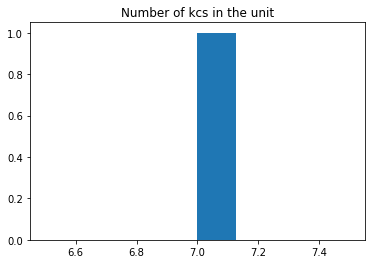

INFO:main:Total number of kcs: 7
INFO:main:count    1.0
mean     7.0
std      NaN
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


In [20]:
# Unit EDA
unit_kcs = [len(unit.kcs) for unit in curric.units]
plt.hist(unit_kcs, bins=8)
plt.title("Number of kcs in the unit")
plt.show()
logger.info("Total number of kcs: %i" % np.sum(unit_kcs))
logger.info(pd.Series(unit_kcs).describe())

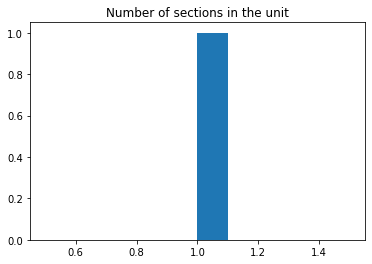

INFO:main:Total number of sections: 1
INFO:main:count    1.0
mean     1.0
std      NaN
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
dtype: float64


In [21]:
#Section EDA
unit_sections = [len(unit.sections) for unit in curric.units]
plt.hist(unit_sections, bins=10)
plt.title("Number of sections in the unit")
plt.show()
logger.info("Total number of sections: %i" % np.sum(unit_sections))
logger.info(pd.Series(unit_sections).describe())

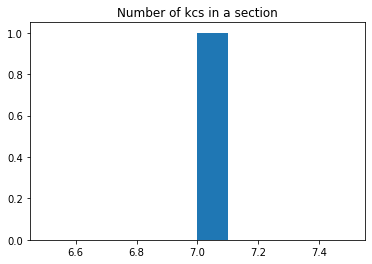

INFO:main:count    1.0
mean     7.0
std      NaN
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


In [22]:
section_kcs = []
for unit in curric.units:
    section_kcs.extend([len(section.kcs) for section in unit.sections])
plt.hist(section_kcs, bins=10)
plt.title("Number of kcs in a section")
plt.show()
logger.info(pd.Series(section_kcs).describe())

INFO:main:Distribution of steps per problems: 
5     43
3     38
4     33
6     22
1     20
2     19
7     12
8      4
9      2
10     1
dtype: int64


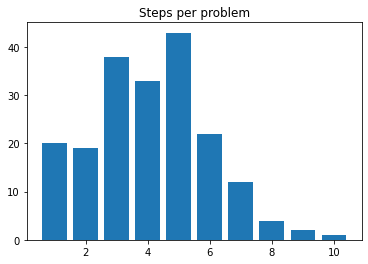

In [23]:
# steps per problem EDA
step_counts = []
for unit in curric.units:
    for section in unit.sections:
 #       logger.info("Section with %i kcs and %i problems" % (len(section.kcs), len(section.problems)))
        counts = pd.Series([len(prob.steps) for prob in section.problems]).value_counts()
#        logger.info("Counts of steps per problems \n%s" % str(counts))
        step_counts.append(counts)

    
prob_steps = pd.DataFrame(step_counts).sum(axis=0)
logger.info("Distribution of steps per problems: \n%s" %  str(prob_steps))
plt.bar(prob_steps.index, prob_steps)
plt.title("Steps per problem")
plt.show()

### Learner Actions EDA

In [24]:
# Get Learner actions
actions = pd.DataFrame(db.actions.find())
actions['type'] = actions.apply(lambda x: x['action']['name'], axis=1)
actions['duration'] = actions.apply(lambda x: x['action']['time'], axis=1)
actions.head()

,_id,student_id,action,time,type,duration
0,ba688a46-2c8c-4e8c-ae18-428797ce1322,1b8bd748-eabf-4992-8e83-6c1b999b5313,"{'name': 'Hint Request', 'time': 3.04347220680...",2020-10-08 20:56:01.267,Hint Request,3.043472
1,fadb543b-9e20-444c-a265-af20965b0956,1b8bd748-eabf-4992-8e83-6c1b999b5313,"{'name': 'Hint Request', 'time': 3.57966369854...",2020-10-08 20:56:04.310,Hint Request,3.579664
2,6197d990-eb42-45a6-8ac5-90bc186f1cae,1b8bd748-eabf-4992-8e83-6c1b999b5313,"{'name': 'Attempt', 'time': 4.9142352647662655...",2020-10-08 20:56:07.890,Attempt,4.914235
3,41606793-0bdc-415a-b391-d69c118432cb,1b8bd748-eabf-4992-8e83-6c1b999b5313,"{'name': 'Hint Request', 'time': 3.73491425632...",2020-10-08 20:56:12.804,Hint Request,3.734914
4,57e005e9-ad3a-4b7c-9c35-be2077130634,1b8bd748-eabf-4992-8e83-6c1b999b5313,"{'name': 'Attempt', 'time': 14.723056600832148...",2020-10-08 20:56:16.539,Attempt,14.723057


In [25]:
action_dist = actions.groupby('student_id')['type'].value_counts().reset_index(name="count")
action_dist = action_dist.pivot(index='student_id', columns='type', values='count')
action_dist['total'] = action_dist.sum(axis=1)
for col in action_dist.columns:
    if col != 'total':
        action_dist['Pct %s' % col] = action_dist.apply(lambda x: x[col]/x['total'], axis=1)
action_dist.head()

type,Attempt,Guess,Hint Request,Off Task,total,Pct Attempt,Pct Guess,Pct Hint Request,Pct Off Task
student_id,,,,,,,,,
1b8bd748-eabf-4992-8e83-6c1b999b5313,395,8,182,48,633,0.624013,0.012638,0.28752,0.075829
299e1bed-a181-42ac-86da-1845fc2b7c25,175,2,64,15,256,0.683594,0.007812,0.25000,0.058594


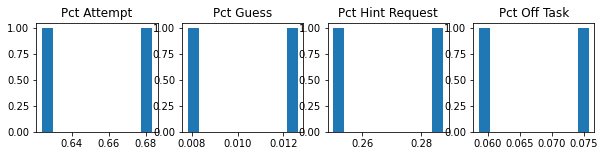

In [26]:
plt.figure(figsize=(10,2))
plt.subplot(141)
plt.hist(action_dist['Pct Attempt'], bins=10)
plt.title("Pct Attempt")

plt.subplot(142)
plt.hist(action_dist['Pct Guess'], bins=10)
plt.title("Pct Guess")

plt.subplot(143)
plt.hist(action_dist['Pct Hint Request'], bins=10)
plt.title("Pct Hint Request")

plt.subplot(144)
plt.hist(action_dist['Pct Off Task'], bins=10)
plt.title("Pct Off Task")

plt.show()

#### Learner Decisions EDA

In [27]:
# Get Learner actions
decisions = pd.DataFrame(db.decisions.find())
decisions['learner_knowledge'] = decisions['learner_knowledge'].apply(lambda x: x[0] if isinstance(x, Iterable) else x)
decisions['kcid'] = decisions['kc'].apply(lambda x: x['_id'])
decisions.head()

,_id,student_id,choice,time,action_evs,pev,problem,step,kc,learner_knowledge,attempt,kcid
0,3730bd47-885d-46a8-abbe-78327d4790dd,1b8bd748-eabf-4992-8e83-6c1b999b5313,HintRequest,2020-10-08 20:56:01.267,"{'Attempt': 0.4, 'Guess': 0.005, 'HintRequest'...","[0.6106870229007634, 0.007633587786259542, 0.3...",59184f41-1880-42c6-a001-1d8f41cc0964,476d5821-4448-41c8-b1bd-93460d3906d3,{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a'...,True,0,f27dc227-e477-4083-a07f-c8208b9c743a
1,75c80fbc-73c5-4941-a6e4-508b5c00ebed,1b8bd748-eabf-4992-8e83-6c1b999b5313,HintRequest,2020-10-08 20:56:04.310,"{'Attempt': 0.4, 'Guess': 0.005, 'HintRequest'...","[0.6106870229007634, 0.007633587786259542, 0.3...",59184f41-1880-42c6-a001-1d8f41cc0964,476d5821-4448-41c8-b1bd-93460d3906d3,{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a'...,True,1,f27dc227-e477-4083-a07f-c8208b9c743a
2,346b7fbc-6ec3-405e-b8d8-adea63cd24ef,1b8bd748-eabf-4992-8e83-6c1b999b5313,Attempt,2020-10-08 20:56:07.890,"{'Attempt': 0.4, 'Guess': 0.005, 'HintRequest'...","[0.6106870229007634, 0.007633587786259542, 0.3...",59184f41-1880-42c6-a001-1d8f41cc0964,476d5821-4448-41c8-b1bd-93460d3906d3,{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a'...,True,2,f27dc227-e477-4083-a07f-c8208b9c743a
3,90445eca-5f80-4fa1-bcf9-ff558f4df95f,1b8bd748-eabf-4992-8e83-6c1b999b5313,HintRequest,2020-10-08 20:56:12.804,"{'Attempt': 0.4, 'Guess': 0.005, 'HintRequest'...","[0.6106870229007634, 0.007633587786259542, 0.3...",59184f41-1880-42c6-a001-1d8f41cc0964,257cd40b-7b52-455f-82f2-e5f7ca2f3f31,{'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f'...,True,0,3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f
4,b0a08960-c502-4e94-baf1-92a0ba78a0e4,1b8bd748-eabf-4992-8e83-6c1b999b5313,Attempt,2020-10-08 20:56:16.539,"{'Attempt': 0.4, 'Guess': 0.005, 'HintRequest'...","[0.6106870229007634, 0.007633587786259542, 0.3...",59184f41-1880-42c6-a001-1d8f41cc0964,257cd40b-7b52-455f-82f2-e5f7ca2f3f31,{'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f'...,True,1,3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f


In [28]:
decisions[['problem', 'step', 'kcid', 'learner_knowledge', 'choice']].head(20)

,problem,step,kcid,learner_knowledge,choice
0,59184f41-1880-42c6-a001-1d8f41cc0964,476d5821-4448-41c8-b1bd-93460d3906d3,f27dc227-e477-4083-a07f-c8208b9c743a,True,HintRequest
1,59184f41-1880-42c6-a001-1d8f41cc0964,476d5821-4448-41c8-b1bd-93460d3906d3,f27dc227-e477-4083-a07f-c8208b9c743a,True,HintRequest
2,59184f41-1880-42c6-a001-1d8f41cc0964,476d5821-4448-41c8-b1bd-93460d3906d3,f27dc227-e477-4083-a07f-c8208b9c743a,True,Attempt
3,59184f41-1880-42c6-a001-1d8f41cc0964,257cd40b-7b52-455f-82f2-e5f7ca2f3f31,3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f,True,HintRequest
4,59184f41-1880-42c6-a001-1d8f41cc0964,257cd40b-7b52-455f-82f2-e5f7ca2f3f31,3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f,True,Attempt
5,59184f41-1880-42c6-a001-1d8f41cc0964,4221ab13-f132-4013-9622-4e430caf50a2,0dd53b3f-5620-4b71-b45a-7023a536a656,True,Attempt
6,59184f41-1880-42c6-a001-1d8f41cc0964,c103e88e-083f-4b41-ab36-5c3042ddda5c,3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f,True,Attempt
7,59184f41-1880-42c6-a001-1d8f41cc0964,c103e88e-083f-4b41-ab36-5c3042ddda5c,3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f,True,OffTask
8,59184f41-1880-42c6-a001-1d8f41cc0964,c103e88e-083f-4b41-ab36-5c3042ddda5c,3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f,True,HintRequest
9,59184f41-1880-42c6-a001-1d8f41cc0964,c103e88e-083f-4b41-ab36-5c3042ddda5c,3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f,True,HintRequest


In [29]:
print(decisions['kc'][0])
print(decisions['action_evs'][0])
print(decisions['pev'][0])

{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a', 'domain_id': '51541d25-fb28-442a-8305-5ca4f6ab5332', 'pl0': 0.5405678450225118, 'pt': 0.20734908002887625, 'ps': 0.03138556613477249, 'pg': 0.8971131808596167, 'm_time': 8.463481123201, 'sd_time': 2.11587028080025}
{'Attempt': 0.4, 'Guess': 0.005, 'HintRequest': 0.2, 'OffTask': 0.05}
[0.6106870229007634, 0.007633587786259542, 0.3053435114503817, 0.07633587786259542]


In [30]:
decision_kc_stats = decisions.groupby(['student_id', 'kcid'])['learner_knowledge'].agg(['count', 'sum'])
decision_kc_stats.head(50)

count  \
student_id                           kcid                                          
1b8bd748-eabf-4992-8e83-6c1b999b5313 0dd53b3f-5620-4b71-b45a-7023a536a656     74   
                                     3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f     84   
                                     44e38ff1-5f93-49ae-9fb1-c71362915390     54   
                                     830fb4cb-0ebe-4864-aeae-a1026bf21956     88   
                                     d83b7f5a-bd98-423a-85cf-dd911deaa2c5    105   
                                     efee908e-dfc0-472c-b4f5-0b343c3b8bd5     72   
                                     f27dc227-e477-4083-a07f-c8208b9c743a    156   
299e1bed-a181-42ac-86da-1845fc2b7c25 0dd53b3f-5620-4b71-b45a-7023a536a656     27   
                                     3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f     30   
                                     44e38ff1-5f93-49ae-9fb1-c71362915390     27   
                                     830fb4cb-0ebe-4864-aeae-a1026bf21956     45   
                                     d83b7f5a-bd98-423a-85cf-dd911deaa2c5     50   
                                     efee908e-dfc0-472c-b4f5-0b343c3b8bd5     40   
                                     f27dc227-e477-4083-a07f-c8208b9c743a     37   

                                                                           sum  
student_id                           kcid                                       
1b8bd748-eabf-4992-8e83-6c1b999b5313 0dd53b3f-5620-4b71-b45a-7023a536a656   74  
                                     3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f   84  
                                     44e38ff1-5f93-49ae-9fb1-c71362915390   54  
                                     830fb4cb-0ebe-4864-aeae-a1026bf21956   88  
                                     d83b7f5a-bd98-423a-85cf-dd911deaa2c5   82  
                                     efee908e-dfc0-472c-b4f5-0b343c3b8bd5   69  
                                     f27dc227-e477-4083-a07f-c8208b9c743a  156  
299e1bed-a181-42ac-86da-1845fc2b7c25 0dd53b3f-5620-4b71-b45a-7023a536a656   27  
                                     3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f   30  
                                     44e38ff1-5f93-49ae-9fb1-c71362915390   27  
                                     830fb4cb-0ebe-4864-aeae-a1026bf21956   45  
                                     d83b7f5a-bd98-423a-85cf-dd911deaa2c5   39  
                                     efee908e-dfc0-472c-b4f5-0b343c3b8bd5   40  
                                     f27dc227-e477-4083-a07f-c8208b9c743a   37

#### Learner Transactions EDA

In [31]:
# Get learner transactions
tx = pd.DataFrame(db.tutor_events.find({'type': "Tutor Input"}))
logger.info("Learner Transactions: %s" % str(tx.shape))
tx.head()

INFO:main:Learner Transactions: (826, 17)


,_id,type,time,curric_id,unit_id,section_id,prob_id,step_id,stu_id,duration,outcome,kcs,plt,plt1,hints_used,hints_avail,attempt
0,32e88349-f0aa-4caa-a4cf-cc830550d8e7,Tutor Input,2020-10-08 20:56:04.310,c3b09307-7361-4c93-a8d0-bb52485c863e,20cdd877-13a9-4d9c-b817-a9a9e755cfc5,1436acbe-318e-4535-b9fd-652fdc150763,59184f41-1880-42c6-a001-1d8f41cc0964,476d5821-4448-41c8-b1bd-93460d3906d3,1b8bd748-eabf-4992-8e83-6c1b999b5313,3.043472,Hint,[{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a...,0.540568,0.416706,0,3,0
1,23cc648c-cd13-42f2-a892-dc2dae2735c2,Tutor Input,2020-10-08 20:56:07.890,c3b09307-7361-4c93-a8d0-bb52485c863e,20cdd877-13a9-4d9c-b817-a9a9e755cfc5,1436acbe-318e-4535-b9fd-652fdc150763,59184f41-1880-42c6-a001-1d8f41cc0964,476d5821-4448-41c8-b1bd-93460d3906d3,1b8bd748-eabf-4992-8e83-6c1b999b5313,3.579664,Hint,[{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a...,0.416706,0.416706,1,2,1
2,2f3b15fc-b26a-45c1-9597-5be6926015d8,Tutor Input,2020-10-08 20:56:12.804,c3b09307-7361-4c93-a8d0-bb52485c863e,20cdd877-13a9-4d9c-b817-a9a9e755cfc5,1436acbe-318e-4535-b9fd-652fdc150763,59184f41-1880-42c6-a001-1d8f41cc0964,476d5821-4448-41c8-b1bd-93460d3906d3,1b8bd748-eabf-4992-8e83-6c1b999b5313,4.914235,Correct,[{'_id': 'f27dc227-e477-4083-a07f-c8208b9c743a...,0.416706,0.416706,2,1,2
3,1837bb37-0d75-4c1d-bc16-5f4abe8f0952,Tutor Input,2020-10-08 20:56:16.539,c3b09307-7361-4c93-a8d0-bb52485c863e,20cdd877-13a9-4d9c-b817-a9a9e755cfc5,1436acbe-318e-4535-b9fd-652fdc150763,59184f41-1880-42c6-a001-1d8f41cc0964,257cd40b-7b52-455f-82f2-e5f7ca2f3f31,1b8bd748-eabf-4992-8e83-6c1b999b5313,3.734914,Hint,[{'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f...,0.453592,0.255811,0,3,0
4,5863efc3-63b4-4e4d-a150-7663facaf2ad,Tutor Input,2020-10-08 20:56:31.262,c3b09307-7361-4c93-a8d0-bb52485c863e,20cdd877-13a9-4d9c-b817-a9a9e755cfc5,1436acbe-318e-4535-b9fd-652fdc150763,59184f41-1880-42c6-a001-1d8f41cc0964,257cd40b-7b52-455f-82f2-e5f7ca2f3f31,1b8bd748-eabf-4992-8e83-6c1b999b5313,14.723057,Correct,[{'_id': '3a5e9e0c-b8c9-4562-a8d3-43328ae8b72f...,0.255811,0.255811,1,2,1


In [32]:
# Add kc field that reduces list of kcs to 1 kc
tx['kc'] = tx.apply(lambda x: x['kcs'][0]['_id'], axis=1)

In [33]:
# Aggregate Learner transaction stats

# Total Transaction counts
stu_stats = tx.groupby('stu_id').agg({'_id': 'count', 
                                      'duration': np.sum,
                                     })
stu_stats.rename(columns={'_id': "Total Tx",
                          'duration': 'Total Time'}, 
                         inplace = True)
stu_stats['Total Time(hours)'] = stu_stats['Total Time'].apply(lambda x: x / 3600)
logger.info("Number of students: %i" % stu_stats.shape[0])
logger.info(stu_stats["Total Tx"].describe())

# Total of each outcome
d = tx.groupby(['stu_id','outcome'])['_id'].count().reset_index().pivot(index='stu_id', columns='outcome', values='_id')

# Prorporation of each outcome
stu_stats = pd.concat([stu_stats, d], axis=1)
stu_stats['Pct Correct'] = stu_stats['Correct'] / stu_stats['Total Tx']
stu_stats['Pct Hint'] = stu_stats['Hint'] / stu_stats['Total Tx']
stu_stats['Pct Incorrect'] = stu_stats['Incorrect'] / stu_stats['Total Tx']


logger.info(stu_stats.shape)

logger.info(stu_stats.columns)



INFO:main:Number of students: 2
INFO:main:count      2.000000
mean     413.000000
std      243.244733
min      241.000000
25%      327.000000
50%      413.000000
75%      499.000000
max      585.000000
Name: Total Tx, dtype: float64
INFO:main:(2, 9)
INFO:main:Index(['Total Tx', 'Total Time', 'Total Time(hours)', 'Correct', 'Hint',
       'Incorrect', 'Pct Correct', 'Pct Hint', 'Pct Incorrect'],
      dtype='object')


In [34]:
# Attempts per step


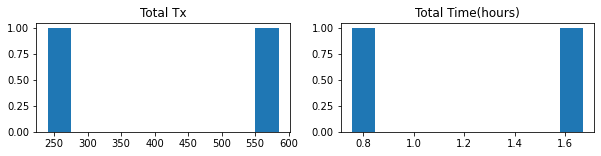

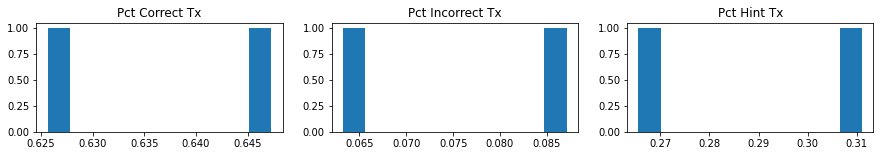

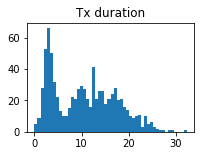

In [35]:
plt.figure(figsize=(10,2))
plt.subplot(121)
plt.hist(stu_stats['Total Tx'], bins=10)
plt.title("Total Tx")

plt.subplot(122)
plt.hist(stu_stats['Total Time(hours)'], bins=10)
plt.title("Total Time(hours)")
plt.show()

plt.figure(figsize=(15,2))
plt.subplot(131)
plt.hist(stu_stats['Pct Correct'], bins=10)
plt.title("Pct Correct Tx")

plt.subplot(132)
plt.hist(stu_stats['Pct Incorrect'], bins=10)
plt.title("Pct Incorrect Tx")

plt.subplot(133)
plt.hist(stu_stats['Pct Hint'], bins=10)
plt.title("Pct Hint Tx")
plt.show()

plt.figure(figsize=(3,2))
plt.hist(tx['duration'],bins=50)
plt.title("Tx duration")
plt.show()

In [36]:
step_stats = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['duration'].agg(['sum', 'count']).reset_index()
stu_prob_stats = step_stats.groupby('stu_id')['count'].describe()
stu_prob_stats.columns = ["Step Attempt %s" % col for col in stu_prob_stats.columns]
d = step_stats.groupby('stu_id')['sum'].describe()
d.columns = ["Step Duration %s" % col for col in d.columns]
stu_prob_stats = pd.concat([stu_prob_stats, d], axis=1)
stu_prob_stats.head()

# kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count()
stu_kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
stu_kc_stats.rename(columns={'step_id': 'kc opportunities'}, inplace=True)
kc_stats = stu_kc_stats.groupby('kc').describe()

#prob_stats = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id'])['duration'].count().reset_index()
#section_stats = step_stats.groupby(['stu_id', 'unit_id', 'section_id'])['sum'].agg(['count', np.mean, np.std])
#unit_stats = step_stats.groupby(['stu_id', 'unit_id'])['sum'].agg(['count', np.mean, np.std])


In [37]:
# Number of transactions with negative duration
# This is a sanity check
count = np.sum(tx['duration'] < 0)
logger.info("Number of transactions with negative duration: %i out of %i(%.2f%%)" % (count, tx.shape[0], count * 100 / tx.shape[0]))

INFO:main:Number of transactions with negative duration: 0 out of 826(0.00%)


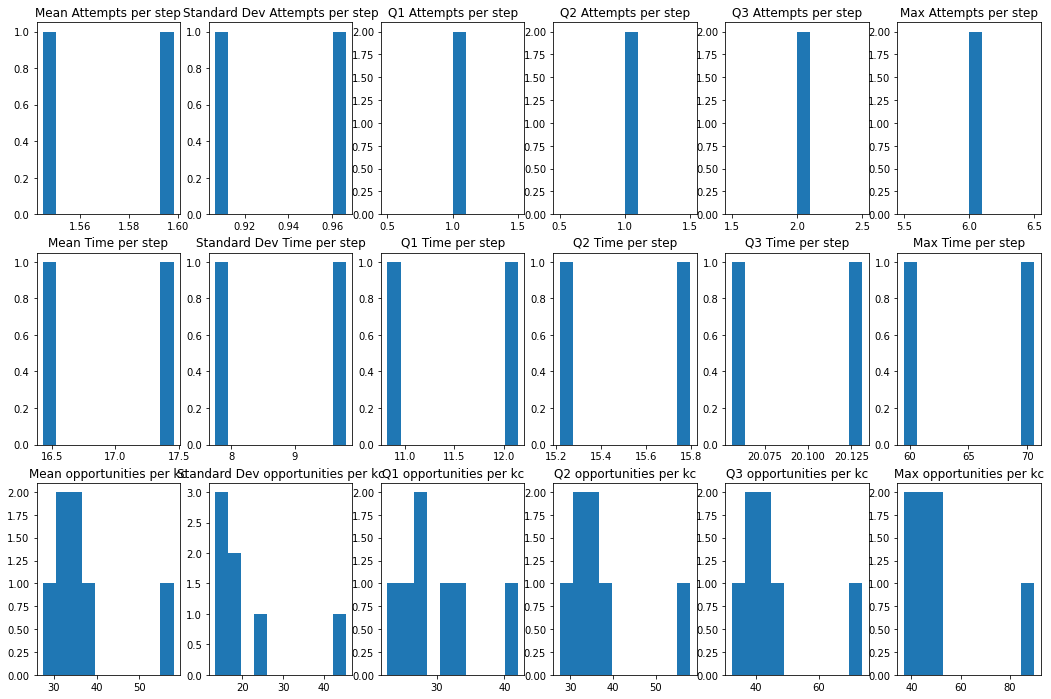

In [38]:
num_bins = 10
num_rows = 3
num_cols = 6
row_height = 3
col_width = 3
plt.figure(figsize=(col_width*num_cols, row_height*num_rows+num_rows))

row = 0
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Attempt mean'], bins=num_bins)
plt.title("Mean Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Attempt std'], bins=num_bins)
plt.title("Standard Dev Attempts per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Attempt 25%'], bins=num_bins)
plt.title("Q1 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Attempt 50%'], bins=num_bins)
plt.title("Q2 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Attempt 75%'], bins=num_bins)
plt.title("Q3 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Attempt max'], bins=num_bins)
plt.title("Max Attempts per step")

row = 1
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Duration mean'], bins=num_bins)
plt.title("Mean Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Duration std'], bins=num_bins)
plt.title("Standard Dev Time per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Duration 25%'], bins=num_bins)
plt.title("Q1 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Duration 50%'], bins=num_bins)
plt.title("Q2 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Duration 75%'], bins=num_bins)
plt.title("Q3 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Duration max'], bins=num_bins)
plt.title("Max Time per step")

row = 2
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(kc_stats[('kc opportunities', 'mean')], bins=num_bins)
plt.title("Mean opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(kc_stats[('kc opportunities', 'std')], bins=num_bins)
plt.title("Standard Dev opportunities per kc")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(kc_stats[('kc opportunities', '25%')], bins=num_bins)
plt.title("Q1 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(kc_stats[('kc opportunities', '50%')], bins=num_bins)
plt.title("Q2 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(kc_stats[('kc opportunities', '75%')], bins=num_bins)
plt.title("Q3 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(kc_stats[('kc opportunities', 'max')], bins=num_bins)
plt.title("Max opportunities per kc")

plt.show()


In [39]:
### 